# Revisit Severson et al.
Peter Attia

This notebook contains most of the figures and code for our paper re-analyzing the dataset in
[Severson et al.](https://energy.stanford.edu/sites/g/files/sbiybj9971/f/346501527888d799d94279cfe74049fde53ca2d5a1275d083d28f925253cf657.pdf)

In [1]:
import copy
import os
import glob
from pathlib import Path
from functools import reduce

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import cm
from matplotlib.ticker import AutoMinorLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd

from scipy.stats import skew, kurtosis
from sklearn import preprocessing
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression, RidgeCV, ElasticNetCV
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from image_annotated_heatmap import heatmap, annotate_heatmap

## Settings

Set plotting settings:

In [2]:
fig_width = 3.25 # ECS spec is 3.25" width
fig_width_2col = 7
fig_height = (3 / 4) * fig_width # standard ratio

rcParams['figure.autolayout'] = True
rcParams['lines.markersize'] = 5
rcParams['lines.linewidth'] = 1.0
rcParams['font.size'] = 7
rcParams['legend.fontsize'] = 7
rcParams['legend.frameon'] = False
rcParams['xtick.minor.visible'] = True
rcParams['ytick.minor.visible'] = True
rcParams['font.sans-serif'] = 'Arial'
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.rm'] = 'Arial'
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

Set path for saving figures:

In [3]:
figpath = Path.cwd() / 'figs'

Define linearly spaced voltage vector (consistent with Severson):

In [4]:
Vdlin = np.linspace(3.6, 2, 1000)

Define `alphas` and `l1_ratios` to use for `RidgeCV` and `ElasticNetCV` hyperparameter optimization:

In [5]:
l1_ratios = [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]
alphas = np.logspace(0.001, 100, 20)

Define colors for train, test1, and test2 to roughly match Severson:

In [6]:
colors_list = ['Blues', 'Reds', 'Oranges']

## Load data
The data is stored in the `data` directory. The data was generated by the `generate_voltage_array.m` MATLAB script, which creates three folders of "voltage arrays" for the train, test1, and test2 splits in Severson et al.

We will load each dataset as 3D arrays of `[cell idx, voltage position, cycle number]`.

Note that because cycle 1 is unavailable for one batch, position 0 in axis 2 is cycle 2.
Similarly, cycle 100 is position 98 in axis 2.
In describing the cycle numbers in the text, I assume the first cycle is cycle 1 (i.e. references to cycle number in the text are one-indexed, not zero-indexed).

In [7]:
def sortKeyFunc(s):
    return int(os.path.basename(s)[4:-4])

def load_dataset(folder):
    files = glob.glob(f'./data/{folder}/*.csv')
    files.sort(key=sortKeyFunc) # glob returns list with arbitrary order
    
    l = len(files)
    dataset = np.zeros((l, 1000, 99))
    
    for k, file in enumerate(files):
        cell = np.genfromtxt(file, delimiter=',')
        dataset[k,:,:] = cell # flip voltage dimension
    
    return dataset

Load three datasets (`test1` = primary test set, `test2` = secondary test set):

In [8]:
data_train = load_dataset('train')
data_test1 = load_dataset('test1')
data_test2 = load_dataset('test2')

Load cycle lives:

In [9]:
cycle_lives_train = np.genfromtxt('./data/cycle_lives/train_cycle_lives.csv', delimiter=',')
cycle_lives_test1 = np.genfromtxt('./data/cycle_lives/test1_cycle_lives.csv', delimiter=',')
cycle_lives_test2 = np.genfromtxt('./data/cycle_lives/test2_cycle_lives.csv', delimiter=',')

Confirm 124 cells are loaded:

In [10]:
print(len(data_train) + len(data_test1) + len(data_test2))
print(len(cycle_lives_train) + len(cycle_lives_test1) + len(cycle_lives_test2))

124
124


Define `y` values as log10 of cycle life:

In [11]:
y_train = np.log10(cycle_lives_train)
y_test1 = np.log10(cycle_lives_test1)
y_test2 = np.log10(cycle_lives_test2)

Make a new version of `data_test1`, `cycle_lives_test1` and `y_test1` that exclude the outlier battery:

In [12]:
data_test1_mod = data_test1.copy()
cycle_lives_test1_mod = cycle_lives_test1.copy()
y_test1_mod = y_test1.copy()

data_test1_mod = np.delete(data_test1_mod, 21, axis=0)
cycle_lives_test1_mod = np.delete(cycle_lives_test1_mod, 21)
y_test1_mod = np.delete(y_test1_mod, 21)

Get median cycle lives for each dataset:

In [13]:
print(np.median(cycle_lives_train))
print(np.median(cycle_lives_test1_mod))
print(np.median(cycle_lives_test2))

527.0
580.0
964.5


Create helper function for reducing RMSE boilerplate:

In [14]:
def get_RMSE_for_all_datasets(y_train_pred, y_test1_pred, y_test2_pred):
    """
    Calculate RMSE for three datasets. Use units of cycles instead of log(cycles)
    """

    RMSE_train = mean_squared_error(np.power(10, y_train), np.power(10, y_train_pred), squared=False)
    RMSE_test1 = mean_squared_error(np.power(10, y_test1_mod), np.power(10, y_test1_pred), squared=False)
    RMSE_test2 = mean_squared_error(np.power(10, y_test2), np.power(10, y_test2_pred), squared=False)

    return RMSE_train, RMSE_test1, RMSE_test2

## Voltage array illustration

This figure illustrates the voltage array (V vs. Q & cycle number) concept.

In [15]:
# Find sample cell in training set
cellNum = 19
sample = data_train[cellNum,:,:]

# Define Qsub and Qdiv (normalized to cycle 2)
Qsub = (sample[:,:].T - sample[:,0]).T
Qdiv = (sample[:,:].T / sample[:,0]).T

# Set voltage indices for linecuts
idx1 = 220
idx2 = 400

Make figure:

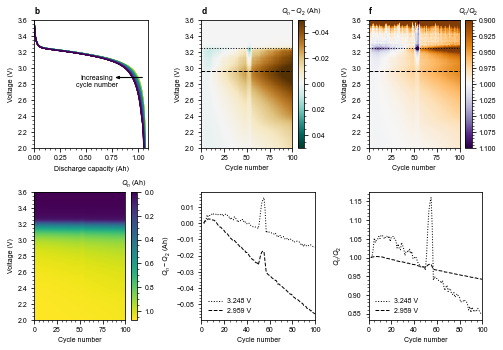

In [16]:
fig, ax = plt.subplots(figsize=(fig_width_2col, 2 * fig_height),
                       nrows=2, ncols=3)
ax = ax.ravel()

colors = cm.get_cmap('viridis_r')(np.linspace(0, 1, 99))

for k in np.arange(3):
    ax[k].set_title(chr(97 + 2*k), loc='left', weight='bold') # a, c, e
    ax[k].set_title(chr(98 + 2*k), loc='left', weight='bold') # b, d, f
    
# Set xlabels
ax[0].set_xlabel('Discharge capacity (Ah)')
ax[0].set_xlim((0,1.1))
for k in np.arange(1, 6):
    ax[k].set_xlabel('Cycle number')
    ax[k].set_xlim([0, 100])
    
# Set ylabels
for k in np.arange(4):
    ax[k].set_ylabel('Voltage (V)')
    ax[k].set_ylim([2, 3.6])
ax[4].set_ylabel(r'$Q_n-Q_2$' + ' (Ah)')
ax[5].set_ylabel(r'$Q_n/Q_2$')

# Panel A: Voltage curves
for k in np.arange(99):
    ax[0].plot(sample[:,k], Vdlin, color=colors[k])
ax[0].arrow(0.95, 0.55, -0.2, 0, transform=ax[0].transAxes,
            zorder=3, head_width=0.02, color='k')
ax[0].text(0.55, 0.52, 'Increasing\ncycle number', horizontalalignment='center',
           verticalalignment='center', transform=ax[0].transAxes)

# Panel B: Voltage matrix
im = ax[3].imshow(sample, extent=[0, 100, 3.6, 2.0],
                  aspect='auto', origin='lower')
cbar = fig.colorbar(im, ax=ax[3])
cbar.ax.set_title(r'$Q_n$'+' (Ah)', fontsize=7)
cbar.ax.invert_yaxis()

# Panel C: Qn - Q2
im1 = ax[1].imshow(Qsub, extent=[0, 100, 3.6, 2.0],
                   aspect='auto', origin='lower',
                   cmap='BrBG', vmin=-0.05, vmax=0.05)

# Panel E: Qn / Q2
im2 = ax[2].imshow(Qdiv, extent=[0, 100, 3.6, 2.0],
                   aspect='auto', origin='lower',
                   cmap='PuOr', vmin=0.9, vmax=1.1)
images = [im1, im2]

# Common to C and E
for k in [1, 2]:
    cbar_title = r'$Q_n-Q_2$'+' (Ah)' if k == 1 else r'$Q_n/Q_2$'
    
    ax[k].axhline(Vdlin[idx1], color='k', ls=':')
    ax[k].axhline(Vdlin[idx2], color='k', ls='--')
    cbar = fig.colorbar(images[k-1], ax=ax[k])
    cbar.ax.invert_yaxis()
    cbar.ax.set_title(cbar_title, fontsize=7)

# Panel D and F: Qn - Q2, Qn / Q2
for k in [4, 5]:
    Qsub_or_Qdiv = Qsub if k == 4 else Qdiv
    
    ax[k].plot(np.arange(2, 101), Qsub_or_Qdiv[idx1,:], 'k', ls=':',  label=f'{Vdlin[idx1]:0.3f} V')
    ax[k].plot(np.arange(2, 101), Qsub_or_Qdiv[idx2,:], 'k', ls='--', label=f'{Vdlin[idx2]:0.3f} V')
    ax[k].legend(loc='lower left')

# Save
plt.tight_layout()
plt.savefig(figpath / 'fig1_voltage_matrix.eps', format='eps')

$Q_n - Q_2$ and $Q_n / Q_2$ contain similar information, but $Q_n / Q_2$ appears more sensitive to temperature fluctuations at its most sensitive point.
For now we proceed with $Q_n - Q_2$ as per Severson.

## Sampling frequency

How frequently do we need to sample the voltage matrix in the voltage dimension?

Define sampling frequencies for illustration plot. Here we use all factors of 1000. 

First make a quick function to get all factors, adapted from [this SO post](https://stackoverflow.com/a/6800214):

In [17]:
def factors(n):
    return sorted(list(reduce(list.__add__,
                              ([i, n//i] for i in range(1, int(n**0.5) + 1) if n % i == 0))))

Get all factors of 1000: 

In [18]:
sampling_frequencies = factors(1000)[:-1] # exclude 1000
sampling_frequencies

[1, 2, 4, 5, 8, 10, 20, 25, 40, 50, 100, 125, 200, 250, 500]

Convert to mV equivalents via `voltage window / (1000 points / n_samples) * (1000 mV/1 V)`:

In [19]:
mV_frequencies = (3.6 - 2.0) / (1000 / np.array(sampling_frequencies)) * 1000 # mV
mV_frequencies

array([  1.6,   3.2,   6.4,   8. ,  12.8,  16. ,  32. ,  40. ,  64. ,
        80. , 160. , 200. , 320. , 400. , 800. ])

Train model on $ \log_{10}($var$(\Delta Q_{100-10}(V) ))$:

In [20]:
RMSE_train = np.zeros((len(sampling_frequencies, )))
RMSE_test1 = np.zeros((len(sampling_frequencies, )))
RMSE_test2 = np.zeros((len(sampling_frequencies, )))

for k, freq in enumerate(sampling_frequencies):
    
    # Define the log10 of the variance of Q100 - Q10, with different sampling frequencies:
    X_train = np.log10(np.var((data_train[:, ::freq, 98] - data_train[:, ::freq, 8]), axis=1))
    X_test1 = np.log10(np.var((data_test1_mod[:, ::freq, 98] - data_test1_mod[:, ::freq, 8]), axis=1))
    X_test2 = np.log10(np.var((data_test2[:, ::freq, 98] - data_test2[:, ::freq, 8]), axis=1))

    # Scale via standarization:
    scaler = preprocessing.StandardScaler().fit(X_train.reshape(-1, 1))
    X_train_scaled = scaler.transform(X_train.reshape(-1, 1))
    X_test1_scaled = scaler.transform(X_test1.reshape(-1, 1))
    X_test2_scaled = scaler.transform(X_test2.reshape(-1, 1))

    # Define and fit linear regression via enet
    enet = ElasticNetCV(l1_ratio=l1_ratios, cv=5, random_state=0)
    enet.fit(X_train_scaled.reshape(-1, 1), y_train)

    # Predict on test sets
    y_train_pred = enet.predict(X_train_scaled)
    y_test1_pred = enet.predict(X_test1_scaled)
    y_test2_pred = enet.predict(X_test2_scaled)
        
    # Evaluate error
    RMSE_train[k], RMSE_test1[k], RMSE_test2[k] = get_RMSE_for_all_datasets(y_train_pred, y_test1_pred, y_test2_pred)

Confirm models match up with Table 1 from Severson: RMSE = (103, 138, 196)

In [21]:
RMSE_train[0], RMSE_test1[0], RMSE_test2[0]

(103.62360099328558, 138.42436354687405, 196.00155811896215)

Looks good, just a very minor difference in training error (103 vs 104). I think this was a mistake in Severson et al

Determine RMSE percent changes from 1000-point case:

In [22]:
RMSE_train_percent_change = 100 * RMSE_train / RMSE_train[0] - 100
RMSE_test1_percent_change = 100 * RMSE_test1 / RMSE_test1[0] - 100
RMSE_test2_percent_change = 100 * RMSE_test2 / RMSE_test2[0] - 100

When does RMSE exceed 1%?

In [23]:
print(f'Train: RMSE > 1% when sampling freq = {mV_frequencies[np.where(np.abs(RMSE_train_percent_change) > 1)[0][0]]} mV')
print(f'Test1: RMSE > 1% when sampling freq = {mV_frequencies[np.where(np.abs(RMSE_test1_percent_change) > 1)[0][0]]} mV')
print(f'Test2: RMSE > 1% when sampling freq = {mV_frequencies[np.where(np.abs(RMSE_test2_percent_change) > 1)[0][0]]} mV')

Train: RMSE > 1% when sampling freq = 40.0 mV
Test1: RMSE > 1% when sampling freq = 40.0 mV
Test2: RMSE > 1% when sampling freq = 160.0 mV


Make figure:

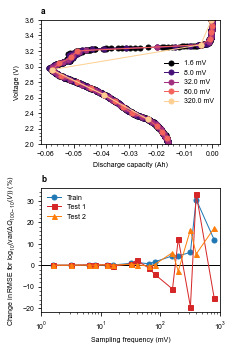

In [24]:
colors = cm.get_cmap('magma')(np.linspace(0, 0.9, 5))

fig, ax = plt.subplots(figsize=(fig_width, 2 * fig_height),
                       nrows=2, ncols=1)
ax = ax.ravel()

ax[0].set_title('a', loc='left', weight='bold')
ax[1].set_title('b', loc='left', weight='bold')

# Panel A: Curves
mV_frequencies_reduced = mV_frequencies[::3]

sample_Qsub = Qsub[:, 98] - Qsub[:, 8] # Q100 - Q10

for k, freq in enumerate(sampling_frequencies[::3]):
    
    ax[0].plot(sample_Qsub[::freq], Vdlin[::freq], '-o',
               color=colors[k], label=f'{mV_frequencies_reduced[k]} mV')

ax[0].set_ylim([2.0, 3.6])
ax[0].set_xlabel('Discharge capacity (Ah)')
ax[0].set_ylabel('Voltage (V)')
ax[0].legend()

# Panel B: RMSE vs frequency
ax[1].semilogx(mV_frequencies, RMSE_train_percent_change, '-o', color='tab:blue', label='Train', zorder=2)
ax[1].semilogx(mV_frequencies, RMSE_test1_percent_change, '-s', color='tab:red', label='Test 1', zorder=2)
ax[1].semilogx(mV_frequencies, RMSE_test2_percent_change, '-^', color='tab:orange', label='Test 2', zorder=2)
ax[1].axhline(0, color='k', zorder=1)
ax[1].set_xlim([1, 1001])
ax[1].set_xlabel('Sampling frequency (mV)')
ax[1].set_ylabel(r'Change in RMSE for $\log_{10}($var$(\Delta Q_{100-10}(V))$ (%)')
ax[1].legend()
    
# Save
plt.tight_layout()
plt.savefig(figpath / 'fig2_sampling_frequency.eps', format='eps')

## Summary statistic features and transformations

Here we try various univariate models, combining different summary statistics with different transforms.

The script is set up so that these lists can be easily modified.

Define summary statistic features to extract from $ \Delta Q_{100-10}(V) $:

In [25]:
functions = {
             '$\Delta Q_{100-10}' + f'({Vdlin[220]:0.3f}$V)':    lambda x: x[:, 220],
             '$\Delta Q_{100-10}' + f'({Vdlin[400]:0.3f}$V)':    lambda x: x[:, 400],
             '$\Delta Q_{100-10}' + f'({Vdlin[-1]:0.3f}$V)':     lambda x: x[:, -1],
             'min($\Delta Q_{100-10}$)' :                        lambda x: np.min(x, axis=1),
             'range($\Delta Q_{100-10}$)' :                      lambda x: np.max(x, axis=1) - np.min(x, axis=1),
             'IDR($\Delta Q_{100-10}$)' :                        lambda x: np.percentile(x, 90, axis=1) - np.percentile(x, 10, axis=1),
             'IQR($\Delta Q_{100-10}$)' :                        lambda x: np.percentile(x, 75, axis=1) - np.percentile(x, 25, axis=1),
             'median($\Delta Q_{100-10}$)':                      lambda x: np.median(x, axis=1),
             'mean($\Delta Q_{100-10}$)':                        lambda x: np.mean(x, axis=1),
             'mean($\Delta Q_{100-10}^2$)':                      lambda x: np.mean(x**2, axis=1),
             'mean($\Delta Q_{100-10}^3$)':                      lambda x: np.mean(x**3, axis=1),
             'var($\Delta Q_{100-10}$)':                         lambda x: np.var(x, axis=1),
             'skew($\Delta Q_{100-10}$)':                        lambda x: skew(x, axis=1),
             'kurt($\Delta Q_{100-10}$)':                        lambda x: kurtosis(x, axis=1),
            }

Define transforms:

In [26]:
transforms = {
              'Original': lambda x: x,
              'sqrt':     lambda x: np.sqrt(np.abs(x)),
              'cbrt':     lambda x: np.cbrt(x),
              r'log$_{10}$':    lambda x: np.log10(np.abs(x)),
             }

Compute $ \Delta Q_{100-10}(V) $:

In [27]:
DeltaQ_100_minus_10_train = data_train[:, :, 98] - data_train[:, :, 8]
DeltaQ_100_minus_10_test1 = data_test1_mod[:, :, 98] - data_test1_mod[:, :, 8]
DeltaQ_100_minus_10_test2 = data_test2[:, :, 98] - data_test2[:, :, 8]

Loop through all summary statistic features and transforms to train the model and evaluate test error. Note that I scale the features here -- not really needed for a univariate model, but good practice anyway:

$\Delta Q_{100-10}(3.248$V)
Original: Skew(train) = -1.042, RMSE(train) = 263.869
sqrt: Skew(train) = 0.225, RMSE(train) = 251.197
cbrt: Skew(train) = 0.024, RMSE(train) = 247.284
log$_{10}$: Skew(train) = -0.476, RMSE(train) = 240.209

$\Delta Q_{100-10}(2.959$V)
Original: Skew(train) = -1.190, RMSE(train) = 213.081
sqrt: Skew(train) = -0.098, RMSE(train) = 137.543
cbrt: Skew(train) = 0.541, RMSE(train) = 120.238
log$_{10}$: Skew(train) = -1.470, RMSE(train) = 112.607

$\Delta Q_{100-10}(2.000$V)
Original: Skew(train) = -3.151, RMSE(train) = 290.926
sqrt: Skew(train) = 1.113, RMSE(train) = 255.141
cbrt: Skew(train) = 1.310, RMSE(train) = 294.164
log$_{10}$: Skew(train) = -0.917, RMSE(train) = 250.589

min($\Delta Q_{100-10}$)
Original: Skew(train) = -1.791, RMSE(train) = 236.721
sqrt: Skew(train) = 0.441, RMSE(train) = 164.089
cbrt: Skew(train) = -0.015, RMSE(train) = 145.517
log$_{10}$: Skew(train) = -0.801, RMSE(train) = 115.531

range($\Delta Q_{100-10}$)
Original: Skew(train) = 1.

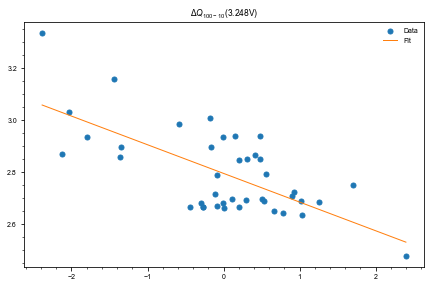

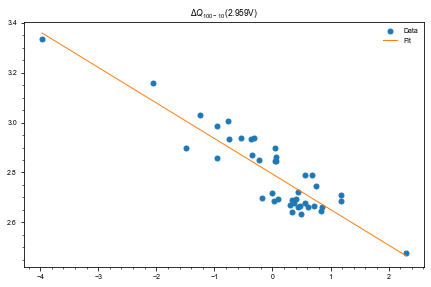

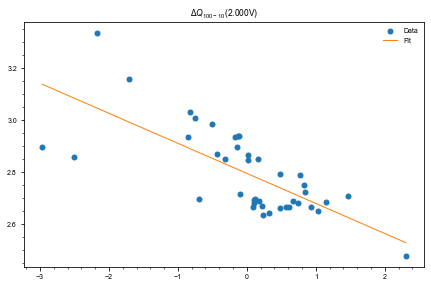

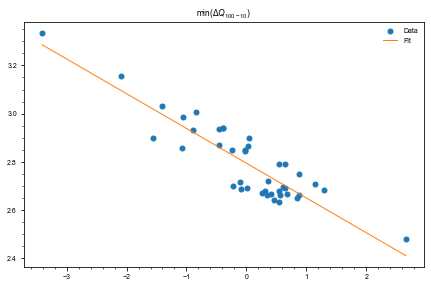

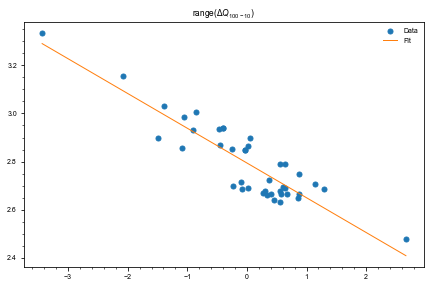

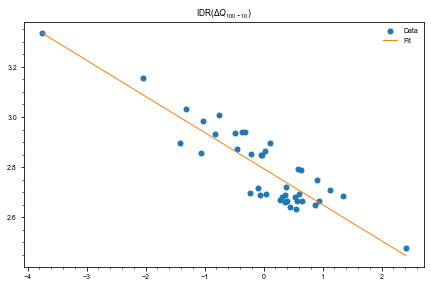

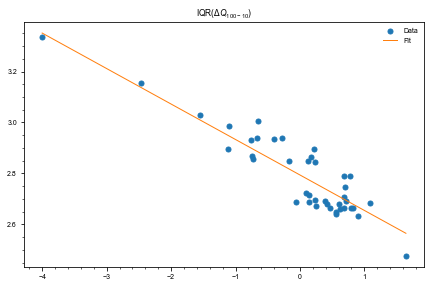

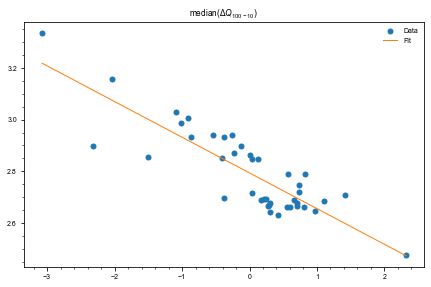

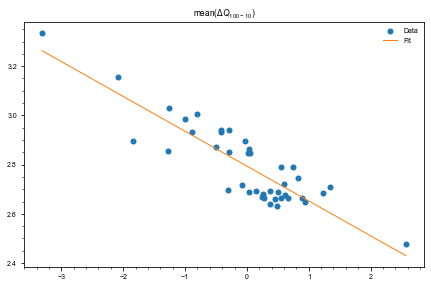

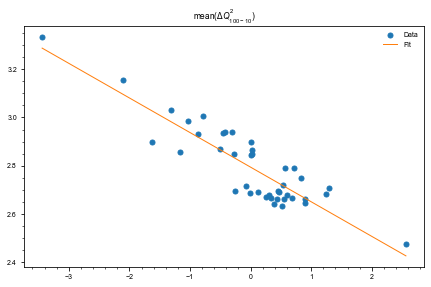

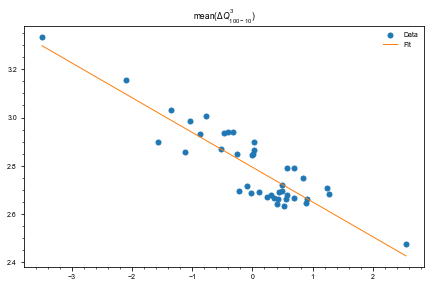

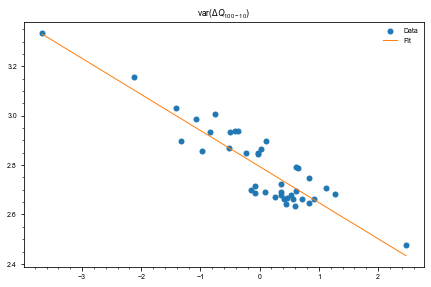

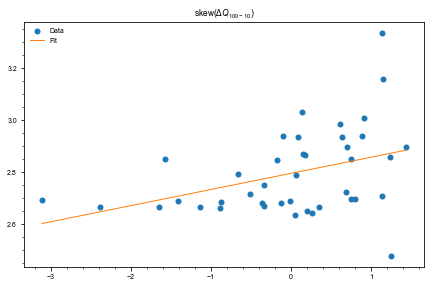

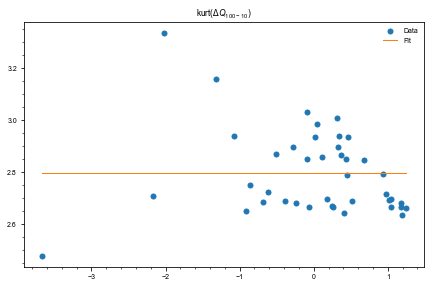

In [28]:
# Preinitialize
RMSE_train = np.zeros((len(functions), len(transforms)))
RMSE_test1 = np.zeros((len(functions), len(transforms)))
RMSE_test2 = np.zeros((len(functions), len(transforms)))
skews = np.zeros((len(functions), len(transforms)))

# Preinitialize
do_raw_features_have_consistently_signed_values = {}

# Loop
for k, func in enumerate(functions):
    
    print(func)
    
    for k2, trans in enumerate(transforms):
        
        # Apply summary statistic to get a single feature per cell
        X_train = functions[func](DeltaQ_100_minus_10_train)
        X_test1 = functions[func](DeltaQ_100_minus_10_test1)
        X_test2 = functions[func](DeltaQ_100_minus_10_test2)
        
        if trans == 'Original':
            do_raw_features_have_consistently_signed_values[func] = (np.sign(np.min(X_train)) == np.sign(np.max(X_train)) and
                                                                     np.sign(np.min(X_test1)) == np.sign(np.max(X_test1)) and
                                                                     np.sign(np.min(X_test2)) == np.sign(np.max(X_test2)))
        else: # apply transform
            transform = transforms[trans]
            X_train, X_test1, X_test2 = transform(X_train), transform(X_test1), transform(X_test2)

        # Scale via standarization
        scaler = preprocessing.StandardScaler().fit(X_train.reshape(-1, 1))
        X_train_scaled = scaler.transform(X_train.reshape(-1, 1))
        X_test1_scaled = scaler.transform(X_test1.reshape(-1, 1))
        X_test2_scaled = scaler.transform(X_test2.reshape(-1, 1))
        
        # Define and fit linear regression via enet
        enet = ElasticNetCV(l1_ratio=l1_ratios, cv=5, random_state=0)
        enet.fit(X_train_scaled, y_train)
        
        # Predict on test sets
        y_train_pred = enet.predict(X_train_scaled)
        y_test1_pred = enet.predict(X_test1_scaled)
        y_test2_pred = enet.predict(X_test2_scaled)

        # Evaluate error
        RMSE_train[k, k2], RMSE_test1[k, k2], RMSE_test2[k, k2] = get_RMSE_for_all_datasets(y_train_pred, y_test1_pred, y_test2_pred)

        # Print stats
        skews[k, k2] = skew(X_train)
        print(f'{trans}: Skew(train) = {skews[k, k2]:0.3f}, RMSE(train) = {RMSE_train[k, k2]:0.3f}')
    
    print()
    
    # make plot for last transformation
    X_fit = np.linspace(np.min(X_train_scaled), np.max(X_train_scaled), 100)
    y_fit = X_fit * enet.coef_[0] + enet.intercept_
    
    plt.figure()
    plt.plot(X_train_scaled, y_train, 'o', label='Data')
    plt.plot(X_fit, y_fit, label='Fit')
    plt.title(func)
    plt.legend()

Remove outliers:

In [29]:
RMSE_test2[0, 2] = np.nan
RMSE_test2[0, 3] = np.nan

Just for fun, here's a quick plot of RMSE vs `skews`:

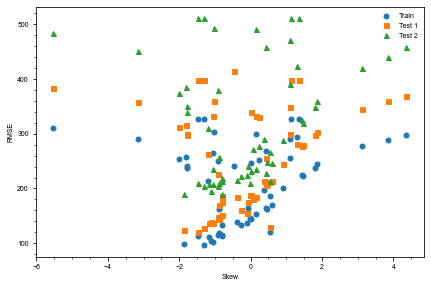

In [30]:
plt.plot(skews.ravel(), RMSE_train.ravel(), 'o', label='Train')
plt.plot(skews.ravel(), RMSE_test1.ravel(), 's', label='Test 1')
plt.plot(skews.ravel(), RMSE_test2.ravel(), '^', label='Test 2')

plt.xlabel('Skew')
plt.ylabel('RMSE')
plt.legend()

Slight correlation but not that interesting.

Plot heat map:

In [31]:
def make_heat_map(RMSE_list, filename):
    fig, ax = plt.subplots(figsize=(fig_width_2col, 2*fig_height),
                           nrows=1, ncols=3)


    # Add astrisk to functions without consistently signed values
    functions_list = list(functions.keys())
    for k, func in enumerate(functions_list):
        if not do_raw_features_have_consistently_signed_values[func]: 
            functions_list[k] = func + '*'

    transforms_list = list(transforms.keys())

    for k in np.arange(3):

        ax[k].set_title(chr(97 + k), loc='left', weight='bold')

        cmap = copy.copy(cm.get_cmap(colors_list[k]))
        cmap.set_bad(color='w')

        im, cbar = heatmap(RMSE_list[k], col_labels=transforms_list, ax=ax[k],
                           row_labels=functions_list if k == 0 else None,
                           cmap=cmap, cbarlabel="RMSE (cycles)")
        texts = annotate_heatmap(im, valfmt="{x:.0f}")

    plt.tight_layout()
    plt.savefig(figpath / filename, format='eps')

<string>:6: UserWarning: Warning: converting a masked element to nan.
/Users/peter/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/Users/peter/anaconda3/lib/python3.7/site-packages/matplotlib/ticker.py:431: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  return self.fmt.format(x=x, pos=pos)


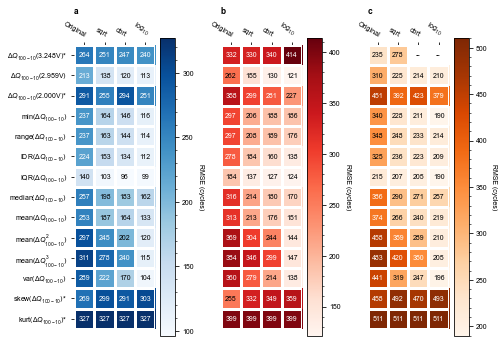

In [32]:
RMSE_list = [RMSE_train, RMSE_test1, RMSE_test2]
make_heat_map(RMSE_list, 'fig3_univariate_heatmap.eps')

## Percentile combinations

Inspired by the success of the IDR and IQR features: Are there any combinations of high and low percentiles that do really well?

First, define a function to take the percentile difference between two percentiles. Return the percentile if `lower_percentile == upper_percentile`:

In [33]:
def take_percentile_diff(x, lower_percentile, upper_percentile):
    
    if lower_percentile > upper_percentile:
        return np.nan
    elif lower_percentile == upper_percentile:
        return np.percentile(x, lower_percentile, axis=1)
    else:
        return np.percentile(x, upper_percentile, axis=1) - np.percentile(x, lower_percentile, axis=1)

Loop through all percentiles combinations. Note that this code block is very slow:

In [34]:
percentiles = np.arange(0, 101)

# Preinitialize NaN arrays
RMSE_train = np.empty((len(percentiles), len(percentiles)))
RMSE_test1 = np.empty((len(percentiles), len(percentiles)))
RMSE_test2 = np.empty((len(percentiles), len(percentiles)))
RMSE_train[:] = np.nan
RMSE_test1[:] = np.nan
RMSE_test2[:] = np.nan

# Just use log10 transform
transform = transforms[r'log$_{10}$']

for k1, lower_percentile in enumerate(percentiles):
    
    if k1 % 10 == 0:
        print(f'{100 * k1 / len(percentiles):.0f}% complete')
    
    for k2, upper_percentile in enumerate(percentiles):
        
        if lower_percentile > upper_percentile:
            continue
        
        # Apply summary statistic to get a single feature per cell
        X_train = take_percentile_diff(DeltaQ_100_minus_10_train, lower_percentile, upper_percentile)
        X_test1 = take_percentile_diff(DeltaQ_100_minus_10_test1, lower_percentile, upper_percentile)
        X_test2 = take_percentile_diff(DeltaQ_100_minus_10_test2, lower_percentile, upper_percentile)
        
        # Apply transform
        X_train, X_test1, X_test2 = transform(X_train), transform(X_test1), transform(X_test2)
        
        # Skip if nonfinite values
        if not np.isfinite(X_train).all() or not np.isfinite(X_test1).all() or not np.isfinite(X_test2).all():
            continue

        # Scale via standarization
        scaler = preprocessing.StandardScaler().fit(X_train.reshape(-1, 1))
        X_train_scaled = scaler.transform(X_train.reshape(-1, 1))
        X_test1_scaled = scaler.transform(X_test1.reshape(-1, 1))
        X_test2_scaled = scaler.transform(X_test2.reshape(-1, 1))

        # Define and fit linear regression via enet
        enet = ElasticNetCV(l1_ratio=l1_ratios, cv=5, random_state=0)
        enet.fit(X_train_scaled, y_train)

        # Predict on test sets
        y_train_pred = enet.predict(X_train_scaled)
        y_test1_pred = enet.predict(X_test1_scaled)
        y_test2_pred = enet.predict(X_test2_scaled)
        
        # Evaluate error
        RMSE_train[k1, k2], RMSE_test1[k1, k2], RMSE_test2[k1, k2] = get_RMSE_for_all_datasets(y_train_pred, y_test1_pred, y_test2_pred)

0% complete
10% complete
20% complete
30% complete
40% complete


/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


50% complete


/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


59% complete


/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


69% complete


/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


79% complete


/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


89% complete


/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


99% complete


Remove outliers:

In [35]:
RMSE_train[RMSE_train > 1000] = np.nan
RMSE_test1[RMSE_test1 > 1000] = np.nan
RMSE_test2[RMSE_test2 > 1000] = np.nan

Display percentile combination that minimizes training error:

In [36]:
train_min_idx = np.unravel_index(np.nanargmin(RMSE_train), RMSE_train.shape)
lower_percentile_train, upper_percentile_train = percentiles[train_min_idx[0]], percentiles[train_min_idx[1]]
lower_percentile_train, upper_percentile_train

(31, 62)

Display percentile combination that minimizes test1 error:

In [37]:
test1_min_idx = np.unravel_index(np.nanargmin(RMSE_test1), RMSE_test1.shape)
percentiles[test1_min_idx[0]], percentiles[test1_min_idx[1]]

(43, 64)

Display percentile combination that minimizes test2 error:

In [38]:
test2_min_idx = np.unravel_index(np.nanargmin(RMSE_test2), RMSE_test2.shape)
percentiles[test2_min_idx[0]], percentiles[test2_min_idx[1]]

(1, 75)

In [39]:
def get_percentiles(vector, lower_percentile, upper_percentile):

    lower_percentile_val = np.percentile(vector, lower_percentile)
    upper_percentile_val = np.percentile(vector, upper_percentile)
    
    low_idx = np.where(vector < lower_percentile_val)[0][0]
    up_idx  = np.where(vector < upper_percentile_val)[0][0]

    return [[Vdlin[low_idx], Vdlin[up_idx]], [lower_percentile_val, upper_percentile_val]]

Plot:

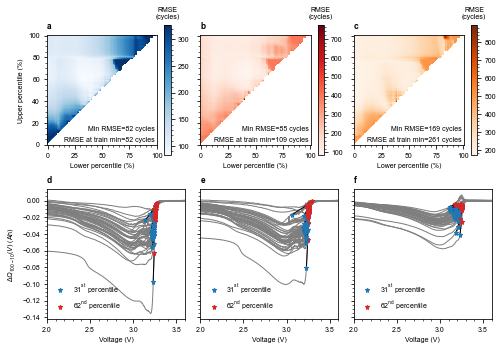

In [40]:
RMSE_list = [RMSE_train, RMSE_test1, RMSE_test2]
DeltaQ_examples = [DeltaQ_100_minus_10_train, DeltaQ_100_minus_10_test1, DeltaQ_100_minus_10_test2]

fig, ax = plt.subplots(figsize=(fig_width_2col, fig_height * 2),
                       nrows=2, ncols=3, sharey='row')
ax = ax.ravel()

for k in np.arange(3):
        
    cmap = copy.copy(cm.get_cmap(colors_list[k]))
    cmap.set_bad(color='w')
    
    im = ax[k].imshow(RMSE_list[k].T, origin='lower', cmap=cmap)
    
    ax[k].set_title(chr(97 + k), loc='left', weight='bold')
    ax[k + 3].set_title(chr(100 + k), loc='left', weight='bold')
    ax[k].set_xlabel('Lower percentile (%)')
    
    cbar = fig.colorbar(im, ax=ax[k])
    cbar.ax.set_title('RMSE\n(cycles)', fontsize=7)
    
    ax[k].text(0.98, 0.15, f'Min RMSE={np.nanmin(RMSE_list[k]):.0f} cycles', horizontalalignment='right',
               verticalalignment='center', transform=ax[k].transAxes)
    ax[k].text(0.98, 0.05, f'RMSE at train min={RMSE_list[k][train_min_idx]:.0f} cycles', horizontalalignment='right',
               verticalalignment='center', transform=ax[k].transAxes)
    
    for example in DeltaQ_examples[k]:
    
        Vdlin_ptiles, vals_ptiles = get_percentiles(example,
                                                    lower_percentile_train,
                                                    upper_percentile_train)
        
        ax[k + 3].plot(Vdlin_ptiles[0], vals_ptiles[0], '*', color='tab:blue', zorder=3)
        ax[k + 3].plot(Vdlin_ptiles[1], vals_ptiles[1], '*', color='tab:red', zorder=3)
        ax[k + 3].plot(Vdlin_ptiles, vals_ptiles, '-k', zorder=2)
        ax[k + 3].plot(Vdlin, example, '-', color='tab:gray', zorder=1)
    
    label1 = f'{lower_percentile_train:.0f}' + r'$\mathrm{^{st}}$ percentile'
    label2 = f'{upper_percentile_train:.0f}' + r'$\mathrm{^{nd}}$ percentile'
        
    ax[k + 3].set_xlabel('Voltage (V)')
    ax[k + 3].set_xlim([2.0, 3.6])
    ax[k + 3].legend([label1, label2])

ax[0].set_ylabel('Upper percentile (%)')
ax[3].set_ylabel('$\Delta Q_{100-10}(V)$ (Ah)')

plt.tight_layout()
plt.savefig(figpath / 'fig6_univariate_percentiles.eps', format='eps')

## Linear cycle life

Repeat analysis but use linear cycle life instead of logged cycle life.

Loop through all summary statistic features and transforms to train the model and evaluate test error:

In [41]:
# Preinitialize
RMSE_train = np.zeros((len(functions), len(transforms)))
RMSE_test1 = np.zeros((len(functions), len(transforms)))
RMSE_test2 = np.zeros((len(functions), len(transforms)))

# Preinitialize
do_raw_features_have_consistently_signed_values = {}

# Loop
for k, func in enumerate(functions):
    
    print(func)
    
    for k2, trans in enumerate(transforms):
        
        # Apply summary statistic to get a single feature per cell
        X_train = functions[func](DeltaQ_100_minus_10_train)
        X_test1 = functions[func](DeltaQ_100_minus_10_test1)
        X_test2 = functions[func](DeltaQ_100_minus_10_test2)
        
        if trans == 'Original':
            do_raw_features_have_consistently_signed_values[func] = (np.sign(np.min(X_train)) == np.sign(np.max(X_train)) and
                                                                     np.sign(np.min(X_test1)) == np.sign(np.max(X_test1)) and
                                                                     np.sign(np.min(X_test2)) == np.sign(np.max(X_test2)))
        else: # apply transform
            transform = transforms[trans]
            X_train, X_test1, X_test2 = transform(X_train), transform(X_test1), transform(X_test2)

        # Scale via standarization
        scaler = preprocessing.StandardScaler().fit(X_train.reshape(-1, 1))
        X_train_scaled = scaler.transform(X_train.reshape(-1, 1))
        X_test1_scaled = scaler.transform(X_test1.reshape(-1, 1))
        X_test2_scaled = scaler.transform(X_test2.reshape(-1, 1))
        
        # Define and fit linear regression via enet
        enet = ElasticNetCV(l1_ratio=l1_ratios, cv=5, random_state=0)
        enet.fit(X_train_scaled, cycle_lives_train)
        
        # Predict on test sets
        y_train_pred = enet.predict(X_train_scaled)
        y_test1_pred = enet.predict(X_test1_scaled)
        y_test2_pred = enet.predict(X_test2_scaled)

        RMSE_train[k, k2] = mean_squared_error(cycle_lives_train, y_train_pred, squared=False)
        RMSE_test1[k, k2] = mean_squared_error(cycle_lives_test1_mod, y_test1_pred, squared=False)
        RMSE_test2[k, k2] = mean_squared_error(cycle_lives_test2, y_test2_pred, squared=False)

        # Print stats
        print(f'{trans}: RMSE(train) = {RMSE_train[k, k2]:0.3f}')
        
    print()

$\Delta Q_{100-10}(3.248$V)
Original: RMSE(train) = 267.901
sqrt: RMSE(train) = 255.847
cbrt: RMSE(train) = 251.998
log$_{10}$: RMSE(train) = 244.861

$\Delta Q_{100-10}(2.959$V)
Original: RMSE(train) = 232.354
sqrt: RMSE(train) = 180.658
cbrt: RMSE(train) = 165.173
log$_{10}$: RMSE(train) = 135.455

$\Delta Q_{100-10}(2.000$V)
Original: RMSE(train) = 289.392
sqrt: RMSE(train) = 260.299
cbrt: RMSE(train) = 272.359
log$_{10}$: RMSE(train) = 240.885

min($\Delta Q_{100-10}$)
Original: RMSE(train) = 248.278
sqrt: RMSE(train) = 203.054
cbrt: RMSE(train) = 185.744
log$_{10}$: RMSE(train) = 157.781

range($\Delta Q_{100-10}$)
Original: RMSE(train) = 248.197
sqrt: RMSE(train) = 203.069
cbrt: RMSE(train) = 185.124
log$_{10}$: RMSE(train) = 156.597

IDR($\Delta Q_{100-10}$)
Original: RMSE(train) = 241.152
sqrt: RMSE(train) = 193.661
cbrt: RMSE(train) = 176.919
log$_{10}$: RMSE(train) = 146.805

IQR($\Delta Q_{100-10}$)
Original: RMSE(train) = 175.976
sqrt: RMSE(train) = 145.052
cbrt: RMSE(train

Remove outliers:

In [42]:
RMSE_test2[0, 2] = np.nan

Plot heat map:

<string>:6: UserWarning: Warning: converting a masked element to nan.
/Users/peter/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/Users/peter/anaconda3/lib/python3.7/site-packages/matplotlib/ticker.py:431: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  return self.fmt.format(x=x, pos=pos)


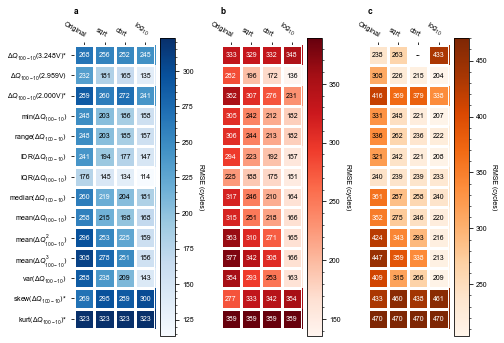

In [43]:
RMSE_list = [RMSE_train, RMSE_test1, RMSE_test2]
make_heat_map(RMSE_list, 'fig4_univariate_heatmap_linear_cycle_life.eps')

## Cycle number averaging (e.g. $ \Delta Q_{98:100-9:11}(V) $ )

For $ \Delta Q_{100-10}(V) $, we are only using two of the available 100 cycles.
This approach is "wasteful" as it doesn't consider similar neighboring cycles.
In this section, we try local averaging over multiple cycles to see if this reduces the noise and improves the predictions.

We use cycles 9, 10, and 11 for the initial cycles and 98, 99, and 100 for the final cycles (to make sure that we still use the first 100 cycles).

In [44]:
functions = {
             '$\Delta Q_{98:100-9:11}' + f'({Vdlin[220]:0.3f}$V)':    lambda x: x[:, 220],
             '$\Delta Q_{98:100-9:11}' + f'({Vdlin[400]:0.3f}$V)':    lambda x: x[:, 400],
             '$\Delta Q_{98:100-9:11}' + f'({Vdlin[-1]:0.3f}$V)':     lambda x: x[:, -1],
             'min($\Delta Q_{98:100-9:11}$)' :                        lambda x: np.min(x, axis=1),
             'range($\Delta Q_{98:100-9:11}$)' :                      lambda x: np.max(x, axis=1) - np.min(x, axis=1),
             'IDR($\Delta Q_{98:100-9:11}$)' :                        lambda x: np.percentile(x, 90, axis=1) - np.percentile(x, 10, axis=1),
             'IQR($\Delta Q_{98:100-9:11}$)' :                        lambda x: np.percentile(x, 75, axis=1) - np.percentile(x, 25, axis=1),
             'median($\Delta Q_{98:100-9:11}$)':                      lambda x: np.median(x, axis=1),
             'mean($\Delta Q_{98:100-9:11}$)':                        lambda x: np.mean(x, axis=1),
             'mean($\Delta Q_{98:100-9:11}^2$)':                      lambda x: np.mean(x**2, axis=1),
             'mean($\Delta Q_{98:100-9:11}^3$)':                      lambda x: np.mean(x**3, axis=1),
             'var($\Delta Q_{98:100-9:11}$)':                         lambda x: np.var(x, axis=1),
             'skew($\Delta Q_{98:100-9:11}$)':                        lambda x: skew(x, axis=1),
             'kurt($\Delta Q_{98:100-9:11}$)':                        lambda x: kurtosis(x, axis=1),
            }

Find $ \Delta Q_{(98:100)-(9:11)}(V) $:

In [45]:
DeltaQ_100_minus_10_train_cycavg = np.mean(data_train[:, :, 96:99], axis=2) - np.mean(data_train[:, :, 7:10], axis=2)
DeltaQ_100_minus_10_test1_cycavg = np.mean(data_test1_mod[:, :, 96:99], axis=2) - np.mean(data_test1_mod[:, :, 7:10], axis=2)
DeltaQ_100_minus_10_test2_cycavg = np.mean(data_test2[:, :, 96:99], axis=2) - np.mean(data_test2[:, :, 7:10], axis=2)

Loop through all summary statistic features and transforms to train the model and evaluate test error:

In [46]:
# Preinitialize
RMSE_train = np.zeros((len(functions), len(transforms)))
RMSE_test1 = np.zeros((len(functions), len(transforms)))
RMSE_test2 = np.zeros((len(functions), len(transforms)))

# Preinitialize
do_raw_features_have_consistently_signed_values = {}

# Loop
for k, func in enumerate(functions):
    
    print(func)
    
    for k2, trans in enumerate(transforms):
        
        # Apply summary statistic to get a single feature per cell
        X_train = functions[func](DeltaQ_100_minus_10_train_cycavg)
        X_test1 = functions[func](DeltaQ_100_minus_10_test1_cycavg)
        X_test2 = functions[func](DeltaQ_100_minus_10_test2_cycavg)
        
        if trans == 'Original':
            do_raw_features_have_consistently_signed_values[func] = (np.sign(np.min(X_train)) == np.sign(np.max(X_train)) and
                                                                     np.sign(np.min(X_test1)) == np.sign(np.max(X_test1)) and
                                                                     np.sign(np.min(X_test2)) == np.sign(np.max(X_test2)))
        else: # apply transform
            transform = transforms[trans]
            X_train, X_test1, X_test2 = transform(X_train), transform(X_test1), transform(X_test2)

        # Scale via standarization
        scaler = preprocessing.StandardScaler().fit(X_train.reshape(-1, 1))
        X_train_scaled = scaler.transform(X_train.reshape(-1, 1))
        X_test1_scaled = scaler.transform(X_test1.reshape(-1, 1))
        X_test2_scaled = scaler.transform(X_test2.reshape(-1, 1))
        
        # Define and fit linear regression via enet
        enet = ElasticNetCV(l1_ratio=l1_ratios, cv=5, random_state=0)
        enet.fit(X_train_scaled, y_train)
        
        # Predict on test sets
        y_train_pred = enet.predict(X_train_scaled)
        y_test1_pred = enet.predict(X_test1_scaled)
        y_test2_pred = enet.predict(X_test2_scaled)

        # Evaluate error
        RMSE_train[k, k2], RMSE_test1[k, k2], RMSE_test2[k, k2] = get_RMSE_for_all_datasets(y_train_pred, y_test1_pred, y_test2_pred)

        # Print stats
        print(f'{trans}: RMSE(train) = {RMSE_train[k, k2]:0.3f}')
        
    print()

$\Delta Q_{98:100-9:11}(3.248$V)
Original: RMSE(train) = 269.383
sqrt: RMSE(train) = 250.183
cbrt: RMSE(train) = 243.138
log$_{10}$: RMSE(train) = 228.576

$\Delta Q_{98:100-9:11}(2.959$V)
Original: RMSE(train) = 209.550
sqrt: RMSE(train) = 134.749
cbrt: RMSE(train) = 117.701
log$_{10}$: RMSE(train) = 109.825

$\Delta Q_{98:100-9:11}(2.000$V)
Original: RMSE(train) = 291.915
sqrt: RMSE(train) = 256.713
cbrt: RMSE(train) = 294.781
log$_{10}$: RMSE(train) = 252.034

min($\Delta Q_{98:100-9:11}$)
Original: RMSE(train) = 228.696
sqrt: RMSE(train) = 149.761
cbrt: RMSE(train) = 130.436
log$_{10}$: RMSE(train) = 111.775

range($\Delta Q_{98:100-9:11}$)
Original: RMSE(train) = 228.433
sqrt: RMSE(train) = 148.519
cbrt: RMSE(train) = 128.942
log$_{10}$: RMSE(train) = 111.278

IDR($\Delta Q_{98:100-9:11}$)
Original: RMSE(train) = 219.940
sqrt: RMSE(train) = 150.507
cbrt: RMSE(train) = 131.724
log$_{10}$: RMSE(train) = 112.230

IQR($\Delta Q_{98:100-9:11}$)
Original: RMSE(train) = 149.445
sqrt: RMS

Remove outliers:

In [47]:
RMSE_test2[0, 2] = np.nan
RMSE_test2[0, 3] = np.nan

Plot heat map:

<string>:6: UserWarning: Warning: converting a masked element to nan.
/Users/peter/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/Users/peter/anaconda3/lib/python3.7/site-packages/matplotlib/ticker.py:431: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  return self.fmt.format(x=x, pos=pos)


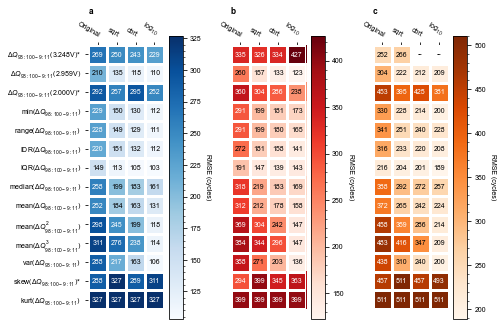

In [48]:
RMSE_list = [RMSE_train, RMSE_test1, RMSE_test2]
make_heat_map(RMSE_list, 'fig5_univariate_heatmap_local_cycle_averaging.eps')

## Single-point voltage prediction

Here, we evaluate the predictive capability of single elements in the voltage array.
Specifically, we evaluate the predictive ability of $ \Delta Q_{100-10}(V) $ at different values of voltage. Fair warning, this block takes a while to run.

In [49]:
sampling_frequency = 1 # every point

# Preinitialize
points = np.arange(0, 1000, sampling_frequency)

RMSE_train = np.zeros((len(points), len(transforms)))
RMSE_test1 = np.zeros((len(points), len(transforms)))
RMSE_test2 = np.zeros((len(points), len(transforms)))
slopes = np.zeros((len(points), len(transforms)))
intercepts = np.zeros((len(points), len(transforms)))
std_devs = np.zeros((len(points), ))

# Loop
for k, point in enumerate(points):
    
    if point % 50 == 0:
        print(f'Starting {k}/{len(points)} ({100*k/len(points):.0f}%)')
    
    # Q_{100 - 10} at different voltages
    X_train = data_train[:, k, 98] - data_train[:, k, 8]
    X_test1 = data_test1_mod[:, k, 98] - data_test1_mod[:, k, 8]
    X_test2 = data_test2[:, k, 98] - data_test2[:, k, 8]
        
    # Calculate std dev of training set
    std_devs[k] = np.std(X_train)
    
    for k2, trans in enumerate(transforms):
        
        # Apply transform
        transform = transforms[trans]
        X_train, X_test1, X_test2 = transform(X_train), transform(X_test1), transform(X_test2)

        # Skip if nonfinite values
        if not np.isfinite(X_train).all() or not np.isfinite(X_test1).all() or not np.isfinite(X_test2).all():
            RMSE_train[k, k2] = np.nan
            RMSE_test1[k, k2] = np.nan
            RMSE_test2[k, k2] = np.nan
            slopes[k, k2] = np.nan
            intercepts[k, k2] = np.nan

        else:
            X_train = X_train.reshape(-1, 1)
            X_test1 = X_test1.reshape(-1, 1)
            X_test2 = X_test2.reshape(-1, 1)
            
            # Define and fit linear regression via enet
            enet = ElasticNetCV(l1_ratio=l1_ratios, cv=5, random_state=0)
            enet.fit(X_train, y_train)

            # Predict on test sets
            y_train_pred = enet.predict(X_train)
            y_test1_pred = enet.predict(X_test1)
            y_test2_pred = enet.predict(X_test2)
            
            # Evaluate error
            RMSE_train[k, k2], RMSE_test1[k, k2], RMSE_test2[k, k2] = get_RMSE_for_all_datasets(y_train_pred, y_test1_pred, y_test2_pred)
            
            # Record slope and intercept
            slopes[k, k2] = enet.coef_[0]
            intercepts[k, k2] = enet.intercept_

Starting 0/1000 (0%)


/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


Starting 50/1000 (5%)
Starting 100/1000 (10%)


/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


Starting 150/1000 (15%)


/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


Starting 200/1000 (20%)
Starting 250/1000 (25%)
Starting 300/1000 (30%)
Starting 350/1000 (35%)
Starting 400/1000 (40%)
Starting 450/1000 (45%)
Starting 500/1000 (50%)
Starting 550/1000 (55%)
Starting 600/1000 (60%)
Starting 650/1000 (65%)
Starting 700/1000 (70%)
Starting 750/1000 (75%)
Starting 800/1000 (80%)
Starting 850/1000 (85%)


/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_l

Starting 900/1000 (90%)


/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_l

Starting 950/1000 (95%)


/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


In [50]:
voltage_of_min_slope = Vdlin[np.nanargmin(slopes[:, 3])]
voltage_of_min_slope_over_std_dev = Vdlin[np.nanargmin(slopes[:, 3] / std_devs)]

print(voltage_of_min_slope)
print(voltage_of_min_slope_over_std_dev)

2.8840840840840842
3.3261261261261263


Make plot:

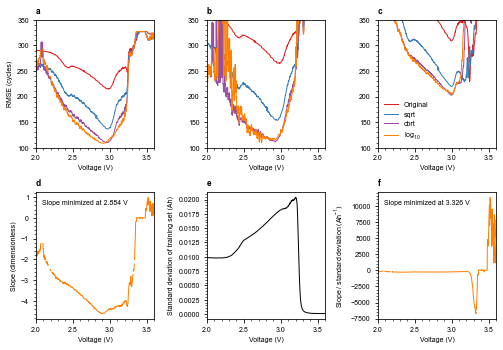

In [51]:
transform_colors = cm.get_cmap('Set1')([0, 1, 3, 4])[:,:3]

fig, ax = plt.subplots(figsize=(fig_width_2col, 2 * fig_height),
                       nrows = 2, ncols = 3)
ax = ax.ravel()

for k in np.arange(6):
    ax[k].set_title(chr(97+k), loc='left', weight='bold')
    ax[k].set_xlim([2, 3.6])
    ax[k].set_xlabel('Voltage (V)')

for k in range(len(transforms)):
    ax[0].plot(Vdlin[points], RMSE_train[:,k], color=transform_colors[k])
    ax[1].plot(Vdlin[points], RMSE_test1[:,k], color=transform_colors[k])
    ax[2].plot(Vdlin[points], RMSE_test2[:,k], color=transform_colors[k])
    
    if k == 3:
        ax[3].plot(Vdlin[points], slopes[:,k], color=transform_colors[k])
        ax[4].plot(Vdlin[points], std_devs, color='k')
        ax[5].plot(Vdlin[points], slopes[:,k] / std_devs, color=transform_colors[k])

for k in np.arange(3):
    ax[k].set_ylim([100, 350])

ax[0].set_ylabel('RMSE (cycles)')
ax[3].set_ylabel('Slope (dimensionless)')
ax[4].set_ylabel('Standard deviation of training set (Ah)')
ax[5].set_ylabel('Slope / standard deviation (Ah$^{-1}$)')

ax[2].legend(list(transforms.keys()))

# Annotations
ax[3].text(0.05, 0.9,
           f'Slope minimized at {voltage_of_min_slope:.3f} V',
           color='k', ha='left', transform=ax[3].transAxes)
ax[5].text(0.05, 0.9,
           f'Slope minimized at {voltage_of_min_slope_over_std_dev:.3f} V',
           color='k', ha='left', transform=ax[5].transAxes)

plt.tight_layout()
plt.savefig(figpath / 'fig7_single_point_prediction.eps', format='eps')

What is the minimum RMSE values for the log10 model?

In [52]:
np.nanmin(RMSE_train[:,3]), np.nanmin(RMSE_test1[:,3]), np.nanmin(RMSE_test2[:,3])

(108.53605457737409, 109.4511374415955, 204.45166722359295)

Voltages at which they occur:

In [53]:
Vdlin[np.nanargmin(RMSE_train[:,3])], Vdlin[np.nanargmin(RMSE_test1[:,3])], Vdlin[np.nanargmin(RMSE_test2[:,3])]

(2.9129129129129128, 2.7415415415415416, 2.9993993993993993)

What are the test errors if we evaluate at the voltage that minimizes the training error?

In [54]:
idx_train_min_error = np.nanargmin(RMSE_train[:,3])
RMSE_train[idx_train_min_error,3], RMSE_test1[idx_train_min_error,3], RMSE_test2[idx_train_min_error,3]

(108.53605457737409, 117.95970717568134, 213.5594807644324)

## Multivariate model from univariate $\Delta Q_{100-10}(V)$ features

This section isn't discussed in depth in the paper, but here I tried to build a multivariate model with the $\Delta Q_{100-10}(V)$ features that don't require the absolute value function (i.e. the highest-performing features).

In [55]:
functions = {
             '$\Delta Q_{100-10}' + f'({Vdlin[400]:0.3f}$V)':    lambda x: x[:, 400],
             'min($\Delta Q_{100-10}$)' :                        lambda x: np.min(x, axis=1),
             'range($\Delta Q_{100-10}$)' :                      lambda x: np.max(x, axis=1) - np.min(x, axis=1),
             'IDR($\Delta Q_{100-10}$)' :                        lambda x: np.percentile(x, 90, axis=1) - np.percentile(x, 10, axis=1),
             'IQR($\Delta Q_{100-10}$)' :                        lambda x: np.percentile(x, 75, axis=1) - np.percentile(x, 25, axis=1),
             'median($\Delta Q_{100-10}$)':                      lambda x: np.median(x, axis=1),
             'mean($\Delta Q_{100-10}$)':                        lambda x: np.mean(x, axis=1),
             'mean($\Delta Q_{100-10}^2$)':                      lambda x: np.mean(x**2, axis=1),
             'mean($\Delta Q_{100-10}^3$)':                      lambda x: np.mean(x**3, axis=1),
             'var($\Delta Q_{100-10}$)':                         lambda x: np.var(x, axis=1),
            }

Loop through all summary statistic features and transforms to train the model and evaluate test error:

In [56]:
# Preinitialize
RMSE_train = np.zeros((len(transforms), ))
RMSE_test1 = np.zeros((len(transforms), ))
RMSE_test2 = np.zeros((len(transforms), ))

X_train = np.zeros((len(DeltaQ_100_minus_10_train), len(functions)))
X_test1 = np.zeros((len(DeltaQ_100_minus_10_test1), len(functions)))
X_test2 = np.zeros((len(DeltaQ_100_minus_10_test2), len(functions)))

# Loop
for k, trans in enumerate(transforms):

    for k2, func in enumerate(functions):    

        # Apply summary statistic to get a single feature per cell
        X_train[:, k2] = functions[func](DeltaQ_100_minus_10_train)
        X_test1[:, k2] = functions[func](DeltaQ_100_minus_10_test1)
        X_test2[:, k2] = functions[func](DeltaQ_100_minus_10_test2)
        
    # Apply transform
    transform = transforms[trans]
    X_train, X_test1, X_test2 = transform(X_train), transform(X_test1), transform(X_test2)

    # Scale via standarization
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test1_scaled = scaler.transform(X_test1)
    X_test2_scaled = scaler.transform(X_test2)

    # Define and fit linear regression via enet
    enet = ElasticNetCV(l1_ratio=l1_ratios, cv=5, random_state=0, max_iter=100000)
    enet.fit(X_train_scaled, y_train)

    # Predict on test sets
    y_train_pred = enet.predict(X_train_scaled)
    y_test1_pred = enet.predict(X_test1_scaled)
    y_test2_pred = enet.predict(X_test2_scaled)

    # Evaluate error
    RMSE_train[k], RMSE_test1[k], RMSE_test2[k] = get_RMSE_for_all_datasets(y_train_pred, y_test1_pred, y_test2_pred)

    print(f'{trans}: RMSE_train={RMSE_train[k]:.0f}, RMSE_test1={RMSE_test1[k]:.0f}, RMSE_test2={RMSE_test2[k]:.0f}')

Original: RMSE_train=138, RMSE_test1=183, RMSE_test2=214
sqrt: RMSE_train=105, RMSE_test1=138, RMSE_test2=201
cbrt: RMSE_train=97, RMSE_test1=125, RMSE_test2=196
log$_{10}$: RMSE_train=99, RMSE_test1=133, RMSE_test2=185


Overall, these models are comparable to the simpler univariate models. Why? Probably because the features are highly correlated:

In [57]:
corr = pd.DataFrame(X_train, columns=functions.keys()).corr()
corr.style.background_gradient(cmap='coolwarm')

,$\Delta Q_{100-10}(2.959$V),min($\Delta Q_{100-10}$),range($\Delta Q_{100-10}$),IDR($\Delta Q_{100-10}$),IQR($\Delta Q_{100-10}$),median($\Delta Q_{100-10}$),mean($\Delta Q_{100-10}$),mean($\Delta Q_{100-10}^2$),mean($\Delta Q_{100-10}^3$),var($\Delta Q_{100-10}$)
$\Delta Q_{100-10}(2.959$V),1.000000,0.990109,0.990367,0.995774,0.969571,0.970390,0.987988,0.992791,0.993967,0.995126
min($\Delta Q_{100-10}$),0.990109,1.000000,0.999927,0.995904,0.953506,0.975214,0.994191,0.997429,0.998160,0.996241
range($\Delta Q_{100-10}$),0.990367,0.999927,1.000000,0.996213,0.953767,0.974065,0.993635,0.997213,0.998051,0.996539
IDR($\Delta Q_{100-10}$),0.995774,0.995904,0.996213,1.000000,0.964969,0.967683,0.990175,0.995537,0.997291,0.998783
IQR($\Delta Q_{100-10}$),0.969571,0.953506,0.953767,0.964969,1.000000,0.912619,0.940378,0.952525,0.957425,0.971181
median($\Delta Q_{100-10}$),0.970390,0.975214,0.974065,0.967683,0.912619,1.000000,0.991010,0.984013,0.979859,0.964653
mean($\Delta Q_{100-10}$),0.987988,0.994191,0.993635,0.990175,0.940378,0.991010,1.000000,0.998635,0.997117,0.988781
mean($\Delta Q_{100-10}^2$),0.992791,0.997429,0.997213,0.995537,0.952525,0.984013,0.998635,1.000000,0.999698,0.995136
mean($\Delta Q_{100-10}^3$),0.993967,0.998160,0.998051,0.997291,0.957425,0.979859,0.997117,0.999698,1.000000,0.997203
var($\Delta Q_{100-10}$),0.995126,0.996241,0.996539,0.998783,0.971181,0.964653,0.988781,0.995136,0.997203,1.000000


Yea, they are. What is the median correlation coefficient?

In [58]:
corr.median().median()

0.9957639402918929

0.996 is quite high. So these features are generally redundant with each other, which explains why the multivariate model isn't much better than univariate models.

Interestingly, the corerlation between between the IQR and variance features (the two best performing features) is 0.971, which is lower than the median.

## Learning from the raw features in $ \Delta Q_{100-10}(V) $

In Severson et al. and previous sections, we used summary statistics of $ \Delta Q_{100-10}(V) $ as features for training. In this section, we consider using the raw Q-V pairs as the features instead of the summary statistics. The primary motivation is to aid interpretability by investigating the weights assigned to the various voltages, but this may also improve prediction.

### Define X matrices

Here, each feature is $ \Delta Q_{100-10}(V) $ for a range of voltages.

Note that we use every 10th voltage point in the 1000-point vector (aka 100 points total). I had trouble with elastic net convergence with the full 1000 points. The RMSE for ridge and PLS regression was insensitive to this choice.

In [59]:
# Define sampling frequency
freq = 10

# Define X matrices
X_train = DeltaQ_100_minus_10_train[:, ::freq]
X_test1 = DeltaQ_100_minus_10_test1[:, ::freq]
X_test2 = DeltaQ_100_minus_10_test2[:, ::freq]

# Define X matrices for cyc averaged
X_train_cycavg = DeltaQ_100_minus_10_train_cycavg[:, ::freq]
X_test1_cycavg = DeltaQ_100_minus_10_test1_cycavg[:, ::freq]
X_test2_cycavg = DeltaQ_100_minus_10_test2_cycavg[:, ::freq]

# Scale via standarization
scaler = preprocessing.StandardScaler().fit(X_train)
scaler_cycavg = preprocessing.StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test1_scaled = scaler.transform(X_test1)
X_test2_scaled = scaler.transform(X_test2)

X_train_scaled_cycavg = scaler.transform(X_train_cycavg)
X_test1_scaled_cycavg = scaler.transform(X_test1_cycavg)
X_test2_scaled_cycavg = scaler.transform(X_test2_cycavg)

### Hyperparameter optimization

For the ML methods that don't have methods for automatic hyperparamter optimization via cross-validation, we optimize the hyperparameters up front.

#### PLSR

There's only one hyperparameter here, so the optimization is easy. The below function was adapted from [this page](https://nirpyresearch.com/partial-least-squares-regression-python/).

In [60]:
def optimise_pls_cv(X, y, max_comps=20, plot_components=True):
    """
    Run PLS including a variable number of components, up to max_comps,
    and calculate MSE
    """
    
    components = np.arange(1, max_comps + 1).astype('uint8')
    rmse = np.zeros((len(components), ))
    
    # Loop through all possibilities
    for comp in components:
        pls = PLSRegression(n_components=comp)
        
        # Cross-validation
        y_cv = cross_val_predict(pls, X, 10**y, cv=5)
        rmse[comp - 1] = mean_squared_error(10**y, y_cv, squared=False)
    
    rmsemin = np.argmin(rmse)
    print("Suggested number of components: ", rmsemin+1)
    
    if plot_components is True:
        with plt.style.context(('ggplot')):
            plt.figure()
            plt.plot(components, rmse, '-v', color = 'blue', mfc='blue')
            plt.plot(components[rmsemin], rmse[rmsemin], 'P', ms=10, mfc='red')
            
            plt.xticks(components)
            plt.xlabel('Number of PLS components')
            plt.ylabel('RMSE (cycles)')
            plt.title('PLS')
            plt.xlim(left=-1)
    
    return rmsemin + 1

Find the optimal number of PLS components:

Suggested number of components:  9
Suggested number of components:  8


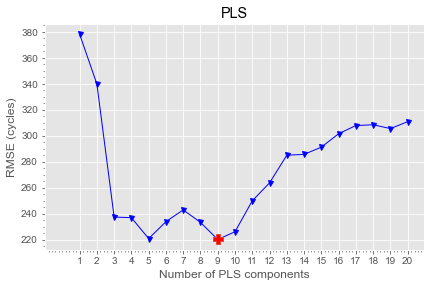

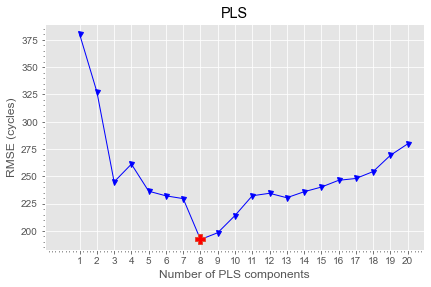

In [61]:
n_comp_plsr = optimise_pls_cv(X_train_scaled, y_train)
n_comp_plsr_cycavg = optimise_pls_cv(X_train_scaled_cycavg, y_train)

### PCR

Similar for PCR, only 1 hyperparameter. Somehow there's no PCR implementation in sklearn

In [62]:
def optimise_pcr_cv(X, y, max_comps=20, plot_components=True):
    """
    Adapted from:
    https://www.kaggle.com/phamvanvung/principal-component-regression/code
    """
    
    # Define the PCA object
    pca = PCA()
    
    # Run PCA producing the reduced variable Xreg and select the first pc components
    Xreg_allcomps = pca.fit_transform(X)
    
    # Define components and preinitialization
    components = np.arange(1, max_comps + 1).astype('uint8')
    rmse = np.zeros((len(components), ))
    
    # Loop through all possibilities
    for comp in components:
    
        Xreg = Xreg_allcomps[:, :comp]

        # Step 2: Regression on selected components
        # Create linear regression object, fit, predict
        lin_reg = LinearRegression()
        lin_reg.fit(Xreg, y)
        y_pred = lin_reg.predict(Xreg)

        # Cross-validation
        y_cv = cross_val_predict(lin_reg, Xreg, y, cv=5)
        rmse[comp - 1] = mean_squared_error(10**y, 10**y_cv, squared=False)
    
    best_n_comps = np.argmin(rmse) + 1
    print(f"Suggested number of components: {best_n_comps}")
    
    if plot_components:
        with plt.style.context(('ggplot')):
            
            fig, ax = plt.subplots(figsize=(12, 4), ncols = 2)
            
            ax[0].plot(components, rmse, '-v', color = 'blue', mfc='blue')
            ax[0].plot(components[best_n_comps - 1], rmse[best_n_comps - 1], 'P', ms=10, mfc='red')
            ax[0].set_xticks(components)
            ax[0].set_xlabel('Number of PC included')
            ax[0].set_ylabel('RMSE (cycles)')
            
            ax[1].plot(components, np.cumsum(pca.explained_variance_ratio_)[:max_comps], '-v', color = 'blue', mfc='blue')
            ax[1].set_xticks(components)
            ax[1].set_xlabel('Number of PC included')
            ax[1].set_ylabel('% Variance explained')
            
            plt.tight_layout()
    
    return best_n_comps

Suggested number of components: 12
Suggested number of components: 12


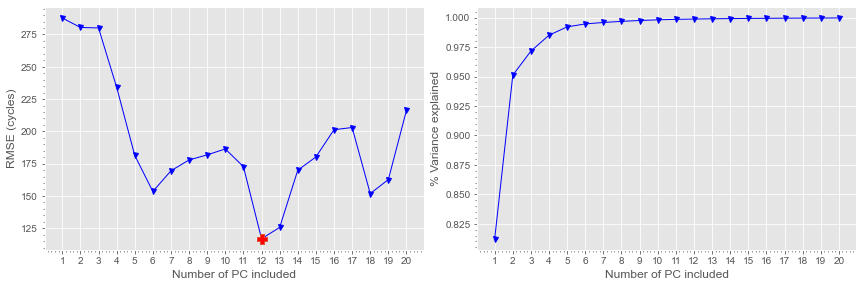

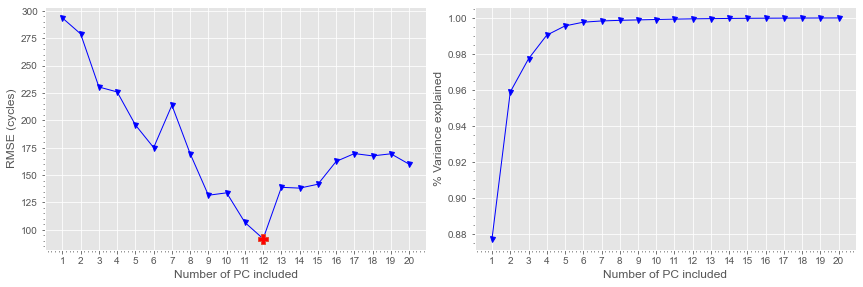

In [63]:
n_comp_pcr = optimise_pcr_cv(X_train_scaled, y_train)
n_comp_pcr_cycavg = optimise_pcr_cv(X_train_scaled_cycavg, y_train)

Odd cyclical trend in this plot.

#### Random forest

There are a lot of hyperparameters for the random forest algorithm, so we use a full-blown randomized search. The below code was adapted from [this page](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74). These seemed like reasonable ranges of hyperparameters but of course it's possible they will miss the optimum.

In [64]:
def optimize_random_forest_cv(X, y):
    
    # Define grid of hyperparameters
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    max_features = ['auto', 'sqrt']
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    bootstrap = [True, False]

    # Define random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

    # Define model and grid
    rf = RandomForestRegressor()
    rf_random = RandomizedSearchCV(estimator = rf,
                                   param_distributions = random_grid,
                                   n_iter = 100,
                                   cv = 5,
                                   verbose = 2,
                                   random_state = 0,
                                   n_jobs = -1)

    # Fit model
    rf_random.fit(X, y)
    
    print(rf_random.best_params_)

    return rf_random

Find RF models:

In [65]:
rf_random = optimize_random_forest_cv(X_train_scaled, y_train)
rf_random_cycavg = optimize_random_forest_cv(X_train_scaled_cycavg, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  8.2min finished


{'n_estimators': 2000, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  8.2min finished


{'n_estimators': 1600, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 100, 'bootstrap': False}


Define models to evaluate:

In [66]:
models = {
          'Ridge': RidgeCV(alphas=alphas, cv=5),
          'Elastic net': ElasticNetCV(l1_ratio=l1_ratios, cv=5, random_state=0, max_iter=100000),
          'PCR': make_pipeline(PCA(n_components=n_comp_pcr), LinearRegression()),
          'PLSR': PLSRegression(n_components=n_comp_plsr),
          'Random Forest': RandomForestRegressor(**rf_random.best_params_)
         }

models_cycavg = {
                 'Ridge': RidgeCV(alphas=alphas, cv=5),
                 'Elastic net': ElasticNetCV(l1_ratio=l1_ratios, cv=5, random_state=0, max_iter=100000),
                 'PCR': make_pipeline(PCA(n_components=n_comp_pcr_cycavg), LinearRegression()),
                 'PLSR': PLSRegression(n_components=n_comp_plsr_cycavg, scale=False),
                 'Random Forest': RandomForestRegressor(**rf_random_cycavg.best_params_)
                 }

model_names = list(models.keys())

Evaluate error and plot:

Ridge RMSE: Train=85 cyc, Test1=125 cyc, Test2=188 cyc
Ridge RMSE, cycavg: Train=86 cyc, Test1=119 cyc, Test2=194 cyc

Elastic net RMSE: Train=92 cyc, Test1=132 cyc, Test2=196 cyc
Elastic net RMSE, cycavg: Train=94 cyc, Test1=126 cyc, Test2=195 cyc

PCR RMSE: Train=80 cyc, Test1=97 cyc, Test2=193 cyc
PCR RMSE, cycavg: Train=80 cyc, Test1=102 cyc, Test2=216 cyc

PLSR RMSE: Train=59 cyc, Test1=100 cyc, Test2=176 cyc
PLSR RMSE, cycavg: Train=65 cyc, Test1=103 cyc, Test2=182 cyc

Random Forest RMSE: Train=82 cyc, Test1=142 cyc, Test2=198 cyc
Random Forest RMSE, cycavg: Train=91 cyc, Test1=136 cyc, Test2=194 cyc



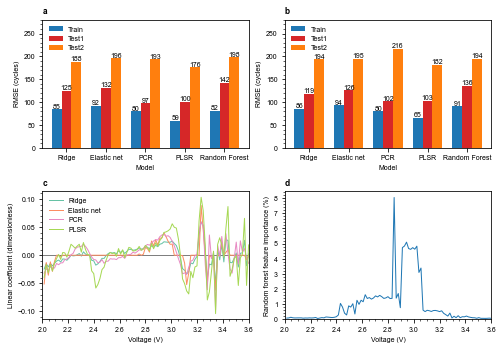

In [67]:
# Preinitialize
RMSE_train = np.zeros((len(models), ))
RMSE_test1 = np.zeros((len(models), ))
RMSE_test2 = np.zeros((len(models), ))

RMSE_train_cycavg = np.zeros((len(models), ))
RMSE_test1_cycavg = np.zeros((len(models), ))
RMSE_test2_cycavg = np.zeros((len(models), ))

# set width of bar
barWidth = 0.25

# model colors
model_colors = cm.get_cmap('Set2')([0, 1, 3, 4])

fig, ax = plt.subplots(figsize=(fig_width_2col, 2 * fig_height),
                       nrows = 2, ncols = 2)
ax = ax.ravel()

for k in np.arange(4):
    ax[k].set_title(chr(97+k), loc='left', weight='bold')

# Add y=0 lines
ax[2].axhline(0, color='tab:gray')


for k, model_name in enumerate(models):
    
    # Get model objects
    model = models[model_name]
    model_cycavg = models_cycavg[model_name]
    
    # Fit models
    model.fit(X_train_scaled, y_train)
    model_cycavg.fit(X_train_scaled_cycavg, y_train)

    # Predict on train and test sets
    y_train_pred = model.predict(X_train_scaled)
    y_test1_pred = model.predict(X_test1_scaled)
    y_test2_pred = model.predict(X_test2_scaled)
    
    y_train_pred_cycavg = model.predict(X_train_scaled_cycavg)
    y_test1_pred_cycavg = model.predict(X_test1_scaled_cycavg)
    y_test2_pred_cycavg = model.predict(X_test2_scaled_cycavg)

    # Evaluate error
    RMSE_train[k], RMSE_test1[k], RMSE_test2[k] = get_RMSE_for_all_datasets(y_train_pred, y_test1_pred, y_test2_pred)
    RMSE_train_cycavg[k], RMSE_test1_cycavg[k], RMSE_test2_cycavg[k] = get_RMSE_for_all_datasets(y_train_pred_cycavg, y_test1_pred_cycavg, y_test2_pred_cycavg)
    
    # Display errors
    print(f'{model_name} RMSE: Train={RMSE_train[k]:.0f} cyc, Test1={RMSE_test1[k]:.0f} cyc, Test2={RMSE_test2[k]:.0f} cyc')
    print(f'{model_name} RMSE, cycavg: Train={RMSE_train_cycavg[k]:.0f} cyc, Test1={RMSE_test1_cycavg[k]:.0f} cyc, Test2={RMSE_test2_cycavg[k]:.0f} cyc\n')
    
    # Add coefficients results to other axes
    if hasattr(model, 'coef_'):
                
        ax[2].plot(Vdlin[::freq], model.coef_, color=model_colors[k], label=model_name)
        
    if model_name == 'PCR': # Special case since coefs aren't an attribute in this pipeline
        
        pcr_lr_coefs = models['PCR'].named_steps['linearregression'].coef_
        pcr_comps = models['PCR'].named_steps['pca'].components_
        pcr_coefs = np.dot(pcr_lr_coefs, pcr_comps)
        coefs_unscaled = pcr_coefs / scaler.scale_
        
        ax[2].plot(Vdlin[::freq], pcr_coefs, color=model_colors[k], label='PCR')
            
    if hasattr(model, 'feature_importances_'): # RF
        ax[3].plot(Vdlin[::freq], 100 * model.feature_importances_)

# Plot error
x = np.arange(len(models))  # the label locations
width = 0.25  # the width of the bars

ax[0].bar(x - width, RMSE_train, width, color='tab:blue', label='Train')
ax[0].bar(x, RMSE_test1, width, color='tab:red', label='Test1')
ax[0].bar(x + width, RMSE_test2, width, color='tab:orange', label='Test2')
ax[0].set_xticks(x)
ax[0].set_xticklabels(models)
ax[0].tick_params(axis='x', which='minor', bottom=False)
ax[0].set_ylim([0, 280])

ax[1].bar(x - width, RMSE_train_cycavg, width, color='tab:blue', label='Train')
ax[1].bar(x, RMSE_test1_cycavg, width, color='tab:red', label='Test1')
ax[1].bar(x + width, RMSE_test2_cycavg, width, color='tab:orange', label='Test2')
ax[1].set_xticks(x)
ax[1].set_xticklabels(models)
ax[1].tick_params(axis='x', which='minor', bottom=False)
ax[1].set_ylim([0, 280])

# Add labels to bar plots
text_offset = 2
for k in x:
    ax[0].text(k - width, RMSE_train[k] + text_offset,
               f'{RMSE_train[k]:.0f}', color='k', ha='center')
    ax[0].text(k, RMSE_test1[k] + text_offset,
               f'{RMSE_test1[k]:.0f}', color='k', ha='center')
    ax[0].text(k + width, RMSE_test2[k] + text_offset,
               f'{RMSE_test2[k]:.0f}', color='k', ha='center')
    
    ax[1].text(k - width, RMSE_train_cycavg[k] + text_offset,
               f'{RMSE_train_cycavg[k]:.0f}', color='k', ha='center')
    ax[1].text(k, RMSE_test1_cycavg[k] + text_offset,
               f'{RMSE_test1_cycavg[k]:.0f}', color='k', ha='center')
    ax[1].text(k + width, RMSE_test2_cycavg[k] + text_offset,
               f'{RMSE_test2_cycavg[k]:.0f}', color='k', ha='center')

    
ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')
ax[2].legend()

ax[0].set_xlabel('Model')
ax[1].set_xlabel('Model')
for k in [2, 3]:
    ax[k].set_xlabel('Voltage (V)')
    ax[k].set_xlim([2.0, 3.6])

ax[3].set_ylim(bottom=0)

ax[0].set_ylabel('RMSE (cycles)')
ax[1].set_ylabel('RMSE (cycles)')
ax[2].set_ylabel('Linear coefficient (dimensionless)')
ax[3].set_ylabel('Random forest feature importance (%)')

plt.tight_layout()
plt.savefig(figpath / 'fig8_multivariate.eps', format='eps')

## Multivariate models explained

Plot coefficients times features for a few example cells

In [68]:
norm = plt.Normalize()
colors = plt.cm.RdBu(norm(cycle_lives_train))

Choose indices in training set (manually sort in ascending order of cycle life):

In [69]:
indices = [20, 30, 10, 1, 0]

Plot:

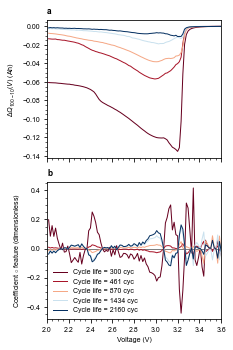

In [70]:
fig, ax = plt.subplots(figsize=(fig_width, 2 * fig_height), nrows = 2, sharex='col')
ax = ax.ravel()


ax[1].axhline(0, color='tab:gray')

for k in np.arange(2):
    ax[k].set_title(chr(97+k), loc='left', weight='bold')

for idx in indices:
    
    label = f'Cycle life = {cycle_lives_train[idx]:.0f} cyc'

    coefs_times_features = (X_train_scaled[idx, :] * models['PLSR'].coef_.T).T

    ax[0].plot(Vdlin[::freq], X_train[idx, :], color=colors[idx])
    ax[1].plot(Vdlin[::freq], coefs_times_features, color=colors[idx], label=label)
    
ax[1].set_xlabel('Voltage (V)')
ax[1].set_xlim([2.0, 3.6])

ax[1].legend()
ax[0].set_ylabel(r'$\Delta Q_{100-10}(V)$ (Ah)')
ax[1].set_ylabel('Coefficient $\circ$ feature (dimensionless)')

plt.tight_layout()
plt.savefig(figpath / 'fig9_multivariate_examples.eps', format='eps')

What is the intercept in terms of cycles?

In [71]:
y_intercept = models['PLSR'].y_mean_ - np.dot(models['PLSR'].x_mean_ , models['PLSR'].coef_)[0]
10 ** y_intercept

array([622.25715302])

## Whole voltage matrix

Here, we use the whole voltage matrix for prediction using a similar approach as above.

In [72]:
# Define sampling frequency (play with this)
freq = 10

# Define X matrices (reshape voltage and cycle number indices into one axis)
# Using Fortran-like reshaping means that the voltage changes before cycle number, so downsampling downsamples voltage
X_train = data_train.reshape(data_train.shape[0], data_train.shape[1] * data_train.shape[2], order='F')[:, ::freq]
X_test1 = data_test1_mod.reshape(data_test1_mod.shape[0], data_test1_mod.shape[1] * data_test1_mod.shape[2], order='F')[:, ::freq]
X_test2 = data_test2.reshape(data_test2.shape[0], data_test2.shape[1] * data_test2.shape[2], order='F')[:, ::freq]

# Scale via standarization
scaler = preprocessing.StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test1_scaled = scaler.transform(X_test1)
X_test2_scaled = scaler.transform(X_test2)

Optimize PLSR:

Suggested number of components:  2


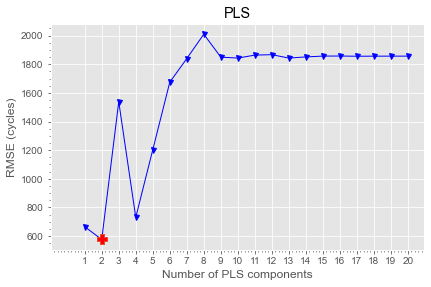

In [73]:
n_comp_plsr = optimise_pls_cv(X_train_scaled, y_train)

Optimize PCR:

Suggested number of components: 18


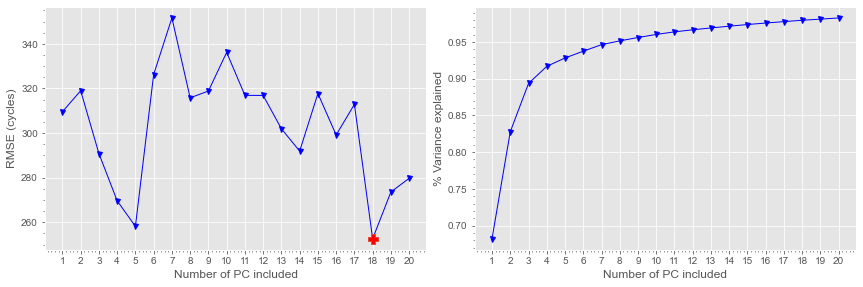

In [74]:
n_comp_pcr = optimise_pcr_cv(X_train_scaled, y_train)

Optimize random forest; this was not run (very slow on my computer, but feel free to uncomment):

In [75]:
#rf_random = optimize_random_forest_cv(X_train_scaled, y_train)

Define models dictionary:

In [76]:
models = {
          'Ridge': RidgeCV(alphas=alphas, cv=5),
          'Elastic net': ElasticNetCV(l1_ratio=l1_ratios, cv=5, random_state=0, max_iter=1000000),
          'PCR': make_pipeline(PCA(n_components=n_comp_pcr), LinearRegression()),
          'PLSR': PLSRegression(n_components=n_comp_plsr),
          #'Random Forest': RandomForestRegressor(**rf_random.best_params_)
         }

Fit and plot:

In [77]:
# Preinitialize
RMSE_train = np.zeros((len(models), ))
RMSE_test1 = np.zeros((len(models), ))
RMSE_test2 = np.zeros((len(models), ))

for k, model_name in enumerate(models):
    
    # Get model object
    model = models[model_name]
    
    # Fit model
    model.fit(X_train_scaled, y_train)

    # Predict on train and test sets
    y_train_pred = model.predict(X_train_scaled)
    y_test1_pred = model.predict(X_test1_scaled)
    y_test2_pred = model.predict(X_test2_scaled)
    
    # Evaluate error
    RMSE_train[k], RMSE_test1[k], RMSE_test2[k] = get_RMSE_for_all_datasets(y_train_pred, y_test1_pred, y_test2_pred)

    # Display errors
    print(f'{model_name} RMSE: Train={RMSE_train[k]:.0f} cyc, Test1={RMSE_test1[k]:.0f} cyc, Test2={RMSE_test2[k]:.0f} cyc')    

Ridge RMSE: Train=0 cyc, Test1=11697 cyc, Test2=357 cyc
Elastic net RMSE: Train=31 cyc, Test1=414 cyc, Test2=365 cyc
PCR RMSE: Train=79 cyc, Test1=597710796 cyc, Test2=328 cyc
PLSR RMSE: Train=203 cyc, Test1=236 cyc, Test2=275 cyc


Severe overfitting. Seems not very promising.

## Line cuts

One final idea is to create line cuts across voltage (i.e. similar to Figure 1d), fit to a line, and fit features.

First, find the voltages with the minimum values for all cells in the training set:

3.002602602602603

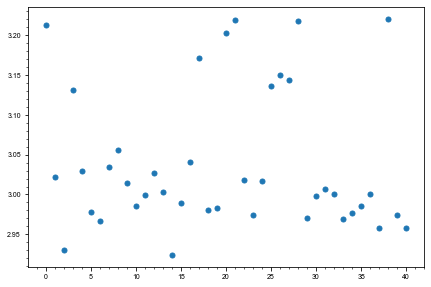

In [78]:
V_max_contrast_indices = np.argmin(DeltaQ_100_minus_10_train, axis=1)
V_max_contrast = Vdlin[V_max_contrast_indices]

plt.plot(V_max_contrast, 'o')

median_V_max_contrast = np.median(V_max_contrast)
median_V_max_contrast

Find the index of max voltage contrast:

In [79]:
V_max_contrast_idx = np.where(Vdlin == median_V_max_contrast)[0][0]
V_max_contrast_idx

373

Define X matrices (start at cycle 10 to avoid initial capacity rise):

In [80]:
X_train = data_train[:, V_max_contrast_idx, 8:].copy()
X_test1 = data_test1_mod[:, V_max_contrast_idx, 8:].copy()
X_test2 = data_test2[:, V_max_contrast_idx, 8:].copy()

Plot all data:

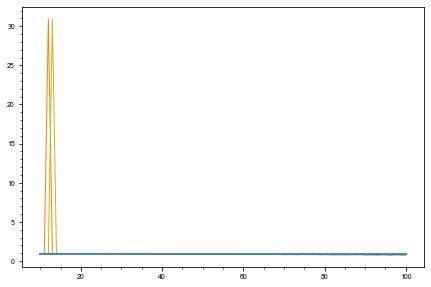

In [81]:
cyc_numbers_start_at_cyc10 = np.arange(X_train.shape[1]) + 10

for k in np.arange(X_train.shape[0]):
    plt.plot(cyc_numbers_start_at_cyc10, X_train[k, :])

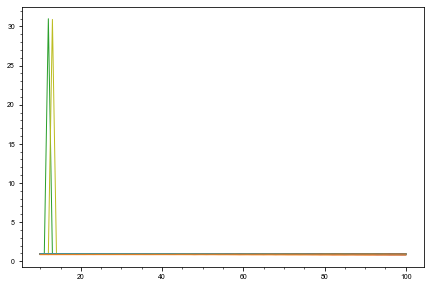

In [82]:
for k in np.arange(X_test1.shape[0]):
    plt.plot(cyc_numbers_start_at_cyc10, X_test1[k, :])

Some of these cells have extreme outliers. Let's filter them out:

In [83]:
def remove_outliers(X, upper_thresh):
    
    # Loop through cell-by-cell
    for k in np.arange(len(X)):

        if np.sum(X[k, :] > upper_thresh) > 0: # Look for outliers

            # Find indices where upper_thresh is exceeded
            idx_greater_than_thresh = np.where(X[k, :] > 1)[0][0]
            
            previous_value = X[k, idx_greater_than_thresh]
            
            # Take median of previous and subsequent point
            X[k, idx_greater_than_thresh] = (X[k, idx_greater_than_thresh - 1] +\
                                                   X[k, idx_greater_than_thresh + 1]) / 2
            
            print(f'Value changed from {previous_value} to {X[k, idx_greater_than_thresh]}')

            print()
            
    return X

In [84]:
X_train = remove_outliers(X_train, 1)
X_test1 = remove_outliers(X_test1, 1)
X_test2 = remove_outliers(X_test2, 1)

Value changed from 30.955 to 0.9325000000000001

Value changed from 30.904 to 0.939065

Value changed from 30.976 to 0.91849

Value changed from 30.887 to 0.91995



Replot:

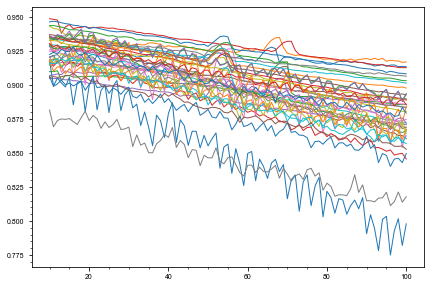

In [85]:
for k in np.arange(X_train.shape[0]):
    plt.plot(cyc_numbers_start_at_cyc10, X_train[k, :])

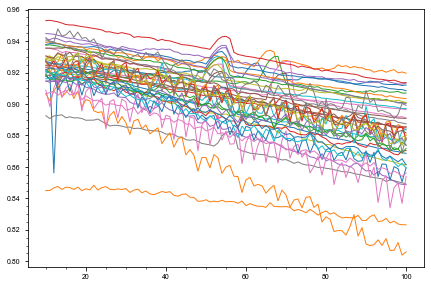

In [86]:
for k in np.arange(X_test1.shape[0]):
    plt.plot(cyc_numbers_start_at_cyc10, X_test1[k, :])

Much better. Overall trends are fairly linear.

Fit trends to a line:

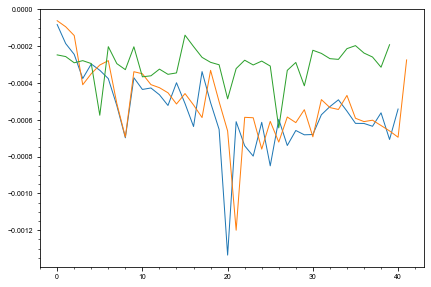

In [87]:
slopes_train, intercepts_train = np.polyfit(cyc_numbers_start_at_cyc10, X_train.T, deg=1)
slopes_test1, intercepts_test1 = np.polyfit(cyc_numbers_start_at_cyc10, X_test1.T, deg=1)
slopes_test2, intercepts_test2 = np.polyfit(cyc_numbers_start_at_cyc10, X_test2.T, deg=1)

X_train_fits = np.vstack([slopes_train, intercepts_train]).T
X_test1_fits = np.vstack([slopes_test1, intercepts_test1]).T
X_test2_fits = np.vstack([slopes_test2, intercepts_test2]).T

plt.plot(slopes_train)
plt.plot(slopes_test1)
plt.plot(slopes_test2)

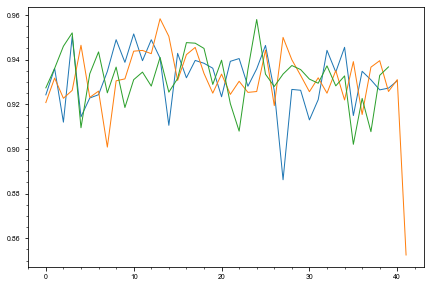

In [88]:
plt.plot(intercepts_train)
plt.plot(intercepts_test1)
plt.plot(intercepts_test2)

Fit slopes and interceps to elastic net model:

In [89]:
enet = ElasticNetCV(l1_ratio=l1_ratios, cv=5, random_state=0)

enet.fit(X_train_fits, y_train)

# Predict on train and test sets
y_train_pred = enet.predict(X_train_fits)
y_test1_pred = enet.predict(X_test1_fits)
y_test2_pred = enet.predict(X_test2_fits)
    
# Evaluate error
RMSE_train, RMSE_test1, RMSE_test2 = get_RMSE_for_all_datasets(y_train_pred, y_test1_pred, y_test2_pred)

print(RMSE_train, RMSE_test1, RMSE_test2)

189.69075860229754 233.02443473180483 268.8288024428003


These errors aren't that impressive.

See trends with slope:

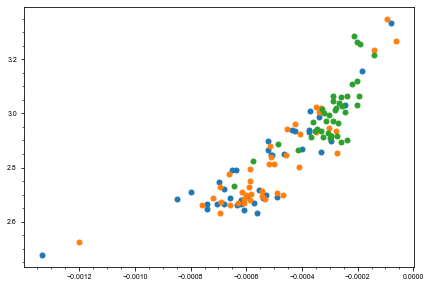

In [90]:
plt.plot(X_train_fits[:, 0], y_train, 'o')
plt.plot(X_test1_fits[:, 0], y_test1_mod, 'o')
plt.plot(X_test2_fits[:, 0], y_test2, 'o')

This looks pretty good overall, so it's kinda surprising that the error was so high.

Another idea is to try adding polynomial features from the slopes and intercepts:

In [91]:
enet = ElasticNetCV(l1_ratio=l1_ratios, cv=5, random_state=0, max_iter=1000000)
poly = preprocessing.PolynomialFeatures(2, include_bias=False)

X_train_fits_poly = poly.fit_transform(X_train_fits)
X_test1_fits_poly = poly.fit_transform(X_test1_fits)
X_test2_fits_poly = poly.fit_transform(X_test2_fits)

enet.fit(X_train_fits_poly, y_train)

# Predict on train and test sets
y_train_pred = enet.predict(X_train_fits_poly)
y_test1_pred = enet.predict(X_test1_fits_poly)
y_test2_pred = enet.predict(X_test2_fits_poly)
    
# Evaluate error
RMSE_train, RMSE_test1, RMSE_test2 = get_RMSE_for_all_datasets(y_train_pred, y_test1_pred, y_test2_pred)

print(RMSE_train, RMSE_test1, RMSE_test2)

190.71184655613186 234.4246062228802 270.4926223539412


Pretty much identical.

### Voltage-averaged line cuts

Here we try the same thing but averaged over 3 voltages.

Define X matrices:

In [92]:
X_train = np.mean(data_train[:, V_max_contrast_idx - 1:V_max_contrast_idx + 2, 8:].copy(), axis=1)
X_test1 = np.mean(data_test1_mod[:, V_max_contrast_idx - 1:V_max_contrast_idx + 2, 8:].copy(), axis=1)
X_test2 = np.mean(data_test2[:, V_max_contrast_idx - 1:V_max_contrast_idx + 2, 8:].copy(), axis=1)

Plot:

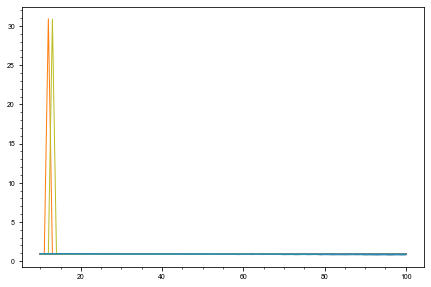

In [93]:
cyc_numbers_start_at_cyc10 = np.arange(X_train.shape[1]) + 10

for k in np.arange(X_train.shape[0]):
    plt.plot(cyc_numbers_start_at_cyc10, X_train[k, :])

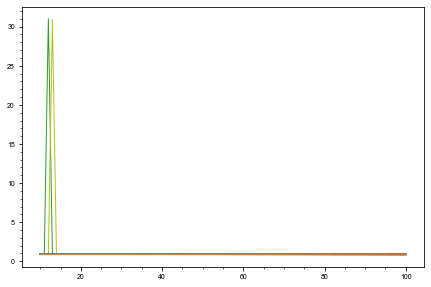

In [94]:
for k in np.arange(X_test1.shape[0]):
    plt.plot(cyc_numbers_start_at_cyc10, X_test1[k, :])

Same problem as before -- remove outliers:

In [95]:
X_train = remove_outliers(X_train, 1)
X_test1 = remove_outliers(X_test1, 1)
X_test2 = remove_outliers(X_test2, 1)

Value changed from 30.948333333333334 to 0.9324933333333334

Value changed from 30.904 to 0.93906

Value changed from 31.013666666666666 to 0.9184766666666666

Value changed from 30.88666666666667 to 0.919945



Confirm this fixed the issue:

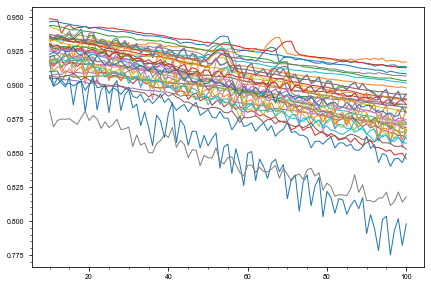

In [96]:
for k in np.arange(X_train.shape[0]):
    plt.plot(cyc_numbers_start_at_cyc10, X_train[k, :])

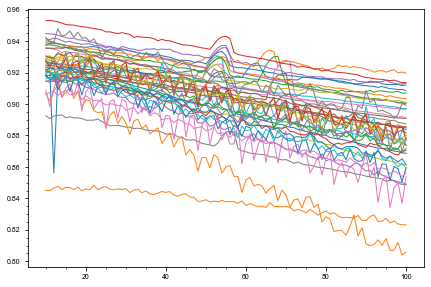

In [97]:
for k in np.arange(X_test1.shape[0]):
    plt.plot(cyc_numbers_start_at_cyc10, X_test1[k, :])

Fit and plot slopes:

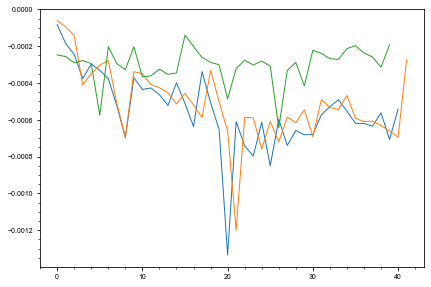

In [98]:
slopes_train, intercepts_train = np.polyfit(cyc_numbers_start_at_cyc10, X_train.T, deg=1)
slopes_test1, intercepts_test1 = np.polyfit(cyc_numbers_start_at_cyc10, X_test1.T, deg=1)
slopes_test2, intercepts_test2 = np.polyfit(cyc_numbers_start_at_cyc10, X_test2.T, deg=1)

X_train_fits = np.vstack([slopes_train, intercepts_train]).T
X_test1_fits = np.vstack([slopes_test1, intercepts_test1]).T
X_test2_fits = np.vstack([slopes_test2, intercepts_test2]).T

plt.plot(slopes_train)
plt.plot(slopes_test1)
plt.plot(slopes_test2)

Plot intercept:

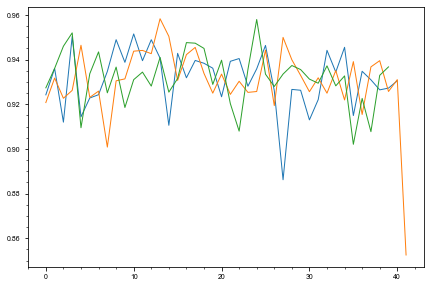

In [99]:
plt.plot(intercepts_train)
plt.plot(intercepts_test1)
plt.plot(intercepts_test2)

Fit and evaluate error:

In [100]:
enet = ElasticNetCV(l1_ratio=l1_ratios, cv=5, random_state=0)

enet.fit(X_train_fits, y_train)

# Predict on train and test sets
y_train_pred = enet.predict(X_train_fits)
y_test1_pred = enet.predict(X_test1_fits)
y_test2_pred = enet.predict(X_test2_fits)
    
# Evaluate error
RMSE_train, RMSE_test1, RMSE_test2 = get_RMSE_for_all_datasets(y_train_pred, y_test1_pred, y_test2_pred)

print(RMSE_train, RMSE_test1, RMSE_test2)

189.67980797403357 232.98175313049208 268.826808194123


Try polynomial features again:

In [101]:
enet = ElasticNetCV(l1_ratio=l1_ratios, cv=5, random_state=0, max_iter=1000000)
poly = preprocessing.PolynomialFeatures(2, include_bias=False)

X_train_fits_poly = poly.fit_transform(X_train_fits)
X_test1_fits_poly = poly.fit_transform(X_test1_fits)
X_test2_fits_poly = poly.fit_transform(X_test2_fits)

enet.fit(X_train_fits_poly, y_train)

# Predict on train and test sets
y_train_pred = enet.predict(X_train_fits_poly)
y_test1_pred = enet.predict(X_test1_fits_poly)
y_test2_pred = enet.predict(X_test2_fits_poly)
    
# Evaluate error
RMSE_train, RMSE_test1, RMSE_test2 = get_RMSE_for_all_datasets(y_train_pred, y_test1_pred, y_test2_pred)

print(RMSE_train, RMSE_test1, RMSE_test2)

190.69992409163112 234.3807829202481 270.4889107312093


This isn't very promising. I think it's reasonable that we need features at many voltages for this to work.

## Conclusions

That's a wrap! Read the paper for more details :)